In [1]:
##################################
### Import the usual libraries ###
##################################

#numpy
import numpy as np

# scipy
from scipy.stats import binned_statistic

#astropy
import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column, QTable

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.offsetbox import AnchoredText

# Yumi's Code to convert (RA,DEC) to MS coordinates
import MagellanicStream as ms

# .py files for grad calc
import astrofunctions as astro
import lmcgeometry as lgeo
import mlefitting as mle
import utilities as util

# Ignore warnings unless crashes
import warnings
warnings.filterwarnings('ignore')

#progress bars
from tqdm import tqdm_notebook

In [2]:
# PARSEC Isochrones
parsecall = ascii.read('/Users/joshuapovick/Desktop/Research/parsec/parsec3_3.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

# LMC r13 data
lmcr13 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/lmc_rgbmembers.r13-l33-58672.fits.gz',1)
cln = np.where((lmcr13['FE_H']>-9999.0)&(lmcr13['AK_TARG']>-9999.0)&(lmcr13['LOGG']>0.0)&
               (lmcr13['M_H_ERR']>-90.0)&(lmcr13['C_FE']>-9999.0)&(lmcr13['N_FE']>-9999.0))

lmc = lmcr13[cln]

In [3]:
### Radii LMC
x,y,dist = lgeo.LMCdisk_cart(lmc['RA'],lmc['DEC'])
radius = lgeo.elliptical_radius(x,y)
     
### All elements APOGEE measures abundances for
elems = ['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','P_FE','S_FE','K_FE','CA_FE','TI_FE',
         'TIII_FE','V_FE','CR_FE','MN_FE','FE_H','CO_FE','NI_FE','CU_FE','GE_FE','RB_FE','CE_FE','ND_FE','YB_FE']
elems_err = ['M_H_ERR','C_FE_ERR','N_FE_ERR','O_FE_ERR','NA_FE_ERR','MG_FE_ERR','AL_FE_ERR','SI_FE_ERR',
             'P_FE_ERR','S_FE_ERR','K_FE_ERR','CA_FE_ERR','TI_FE_ERR','TIII_FE_ERR','V_FE_ERR','CR_FE_ERR',
             'MN_FE_ERR','FE_H_ERR','CO_FE_ERR','NI_FE_ERR','CU_FE_ERR','GE_FE_ERR','RB_FE_ERR','CE_FE_ERR',
             'ND_FE_ERR','YB_FE_ERR']

labs = ['[M/H]','[C/Fe]','[N/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[P/Fe]','[S/Fe]','[K/Fe]',
        '[Ca/Fe','[Ti/FE]','[Ti II/Fe]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]','[Ni/Fe]','[Cu/Fe]',
        '[Ge/Fe]','[Rb/Fe]','[Ce/Fe]','[Nd/Fe]','[Yb/FE]']

In [4]:
##############################
### Fit Overall Trendlines ###
##############################

med_ms = []
med_bs = []

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((lmc[elems[i]]>-100)&(lmc['SNR']>=100))
    
    # fit data
    slope, inter = mle.mle_fit(radius[cln],lmc[elems[i]][cln],lmc[elems_err[i]][cln])
    med_ms.append(slope)
    med_bs.append(inter)

In [5]:
for i in range(len(med_ms)):
    print('{}: slope: {:.4f}; inter: {:.4f}'.format(labs[i],med_ms[i],med_bs[i]))

[M/H]: slope: -0.0415; inter: -0.5888
[C/Fe]: slope: -0.0216; inter: -0.2741
[N/Fe]: slope: -0.0119; inter: 0.1473
[O/Fe]: slope: 0.0027; inter: 0.0240
[Na/Fe]: slope: -0.0041; inter: -0.1725
[Mg/Fe]: slope: 0.0071; inter: 0.0824
[Al/Fe]: slope: -0.0119; inter: -0.3125
[Si/Fe]: slope: 0.0040; inter: -0.0108
[P/Fe]: slope: 0.0331; inter: -0.0136
[S/Fe]: slope: 0.0167; inter: 0.1406
[K/Fe]: slope: 0.0213; inter: -0.0600
[Ca/Fe: slope: -0.0013; inter: 0.1054
[Ti/FE]: slope: 0.0200; inter: -0.1331
[Ti II/Fe]: slope: 0.0306; inter: -0.1668
[V/Fe]: slope: -0.0036; inter: -0.1037
[Cr/Fe]: slope: -0.0062; inter: 0.0620
[Mn/Fe]: slope: -0.0250; inter: -0.0162
[Fe/H]: slope: -0.0374; inter: -0.5944
[Co/Fe]: slope: -0.0049; inter: -0.1298
[Ni/Fe]: slope: 0.0006; inter: -0.1337
[Cu/Fe]: slope: 0.0417; inter: 0.0038


In [6]:
matplotlib.rcParams.update({'font.size': 18})
med_elems_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return med_ms[i]*x+med_bs[i]
    
    cln = np.where((lmc[elems[i]]>-100)&(lmc['SNR']>=100))
    plug = trendline(radius[cln])
    dist = plug-lmc[elems[i]][cln]
    
    med_elems_dist.append(dist)    
    
    bins = np.append(np.arange(np.floor(np.min(radius[cln])),np.ceil(np.max(radius[cln])),1.0),
                     np.ceil(np.max(radius[cln]))+1) 
    bin_dist, _, _ = binned_statistic(radius[cln],dist,statistic='median',bins=bins)
    bin_spr, _, _ = binned_statistic(radius[cln],dist,statistic=lambda y: np.median(np.absolute(y-np.median(y))),
                                     bins=bins)

In [7]:
med_m_devs = []
med_b_devs = []
re_med_ms = []
re_med_bs = []

prune_fact = 3.
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((lmc[elems[i]]>-100)&(lmc['SNR']>=100))
    prune = np.where((lmc[elems[i]]>-prune_fact*util.mad(med_elems_dist[i])+
                      np.median(lmc[cln][elems[i]]))&
                     (lmc[elems[i]]<prune_fact*util.mad(med_elems_dist[i])+
                      np.median(lmc[cln][elems[i]])))

    exog = radius[prune]
    endog = lmc[elems[i]][prune]
    endog_err = lmc[elems_err[i]][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    med_m_devs.append(util.mad(slps))
    med_b_devs.append(util.mad(ints))
    
    re_med_ms.append(np.median(slps))
    re_med_bs.append(np.median(ints))

In [8]:
for i in range(len(re_med_ms)):
    print('{}: slope: {:.4f} +/- {:.4f} inter: {:.4f} +/- {:.4f}'.format(elems[i],re_med_ms[i],med_m_devs[i],
                                                                         re_med_bs[i],med_b_devs[i]))

M_H: slope: -0.0262 +/- 0.0026 inter: -0.6035 +/- 0.0099
C_FE: slope: -0.0177 +/- 0.0018 inter: -0.2750 +/- 0.0066
N_FE: slope: -0.0096 +/- 0.0016 inter: 0.1173 +/- 0.0064
O_FE: slope: 0.0002 +/- 0.0015 inter: 0.0341 +/- 0.0041
NA_FE: slope: 0.0014 +/- 0.0034 inter: -0.1778 +/- 0.0108
MG_FE: slope: 0.0026 +/- 0.0021 inter: 0.0971 +/- 0.0061
AL_FE: slope: -0.0100 +/- 0.0017 inter: -0.3115 +/- 0.0057
SI_FE: slope: 0.0042 +/- 0.0013 inter: -0.0061 +/- 0.0042
P_FE: slope: 0.0244 +/- 0.0042 inter: 0.0340 +/- 0.0145
S_FE: slope: 0.0091 +/- 0.0027 inter: 0.1512 +/- 0.0095
K_FE: slope: 0.0120 +/- 0.0035 inter: -0.0379 +/- 0.0106
CA_FE: slope: -0.0017 +/- 0.0006 inter: 0.1070 +/- 0.0017
TI_FE: slope: 0.0012 +/- 0.0039 inter: -0.1115 +/- 0.0086
TIII_FE: slope: 0.0289 +/- 0.0063 inter: -0.1782 +/- 0.0197
V_FE: slope: -0.0039 +/- 0.0018 inter: -0.0908 +/- 0.0066
CR_FE: slope: -0.0082 +/- 0.0015 inter: 0.0729 +/- 0.0042
MN_FE: slope: -0.0156 +/- 0.0024 inter: -0.0344 +/- 0.0062
FE_H: slope: -0.0223

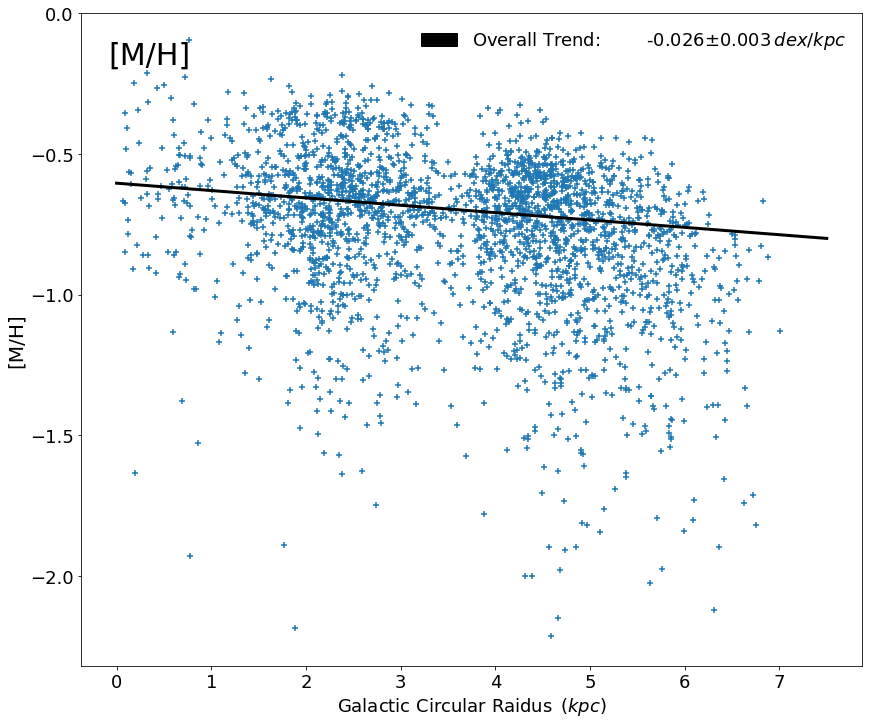

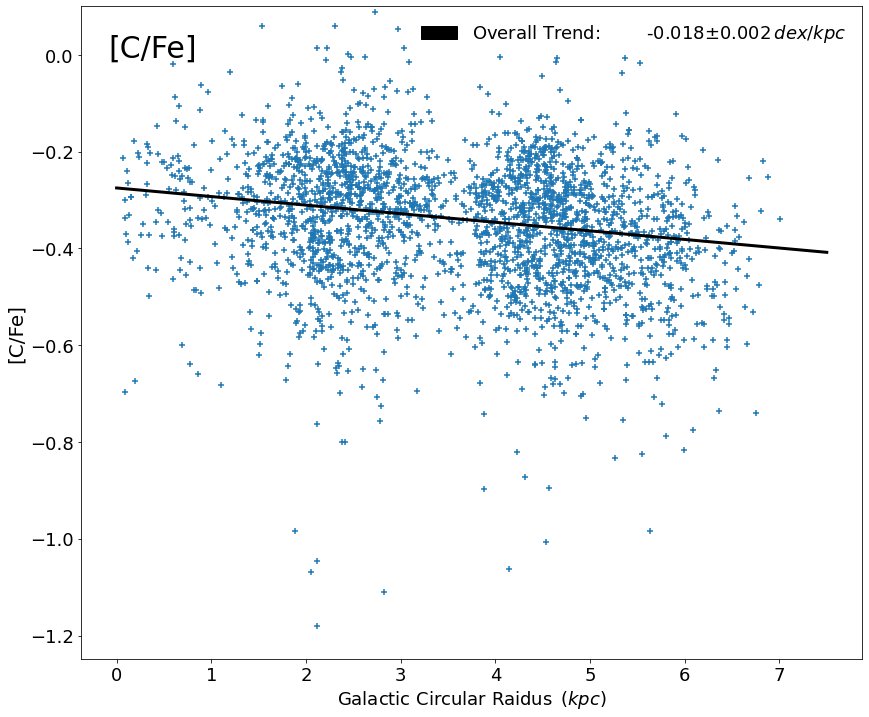

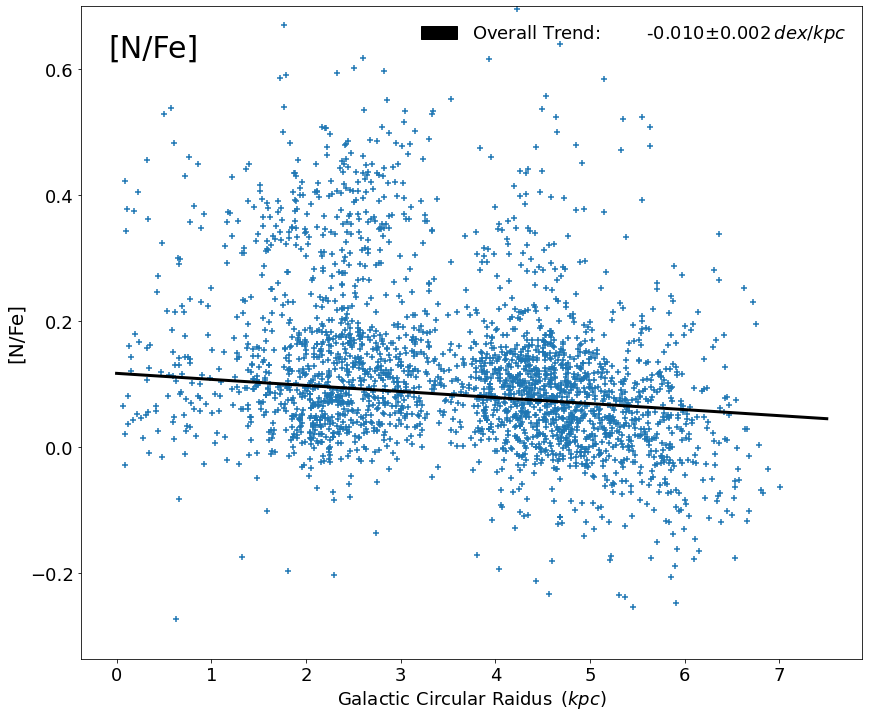

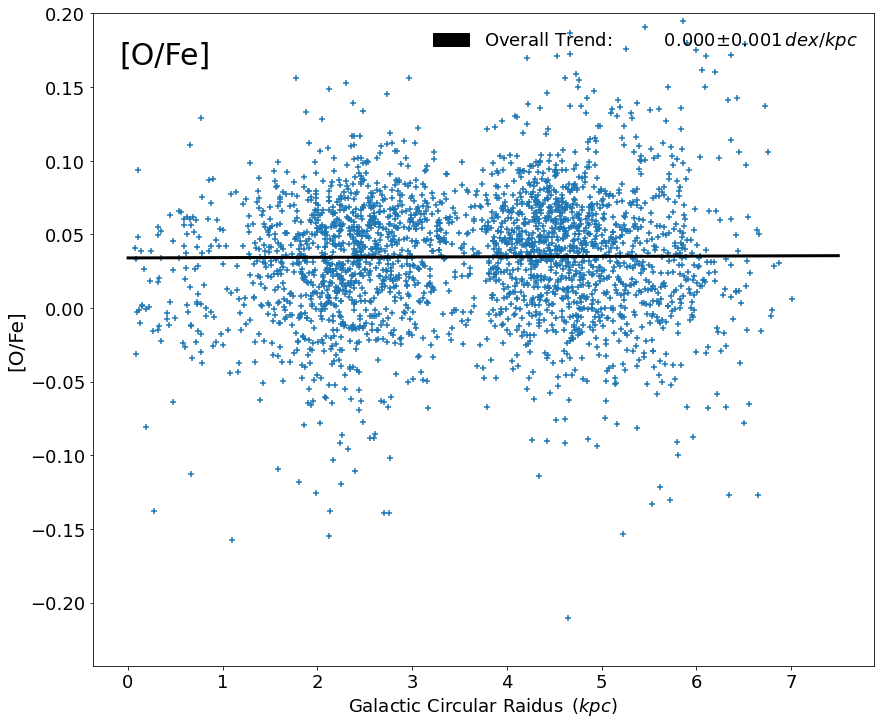

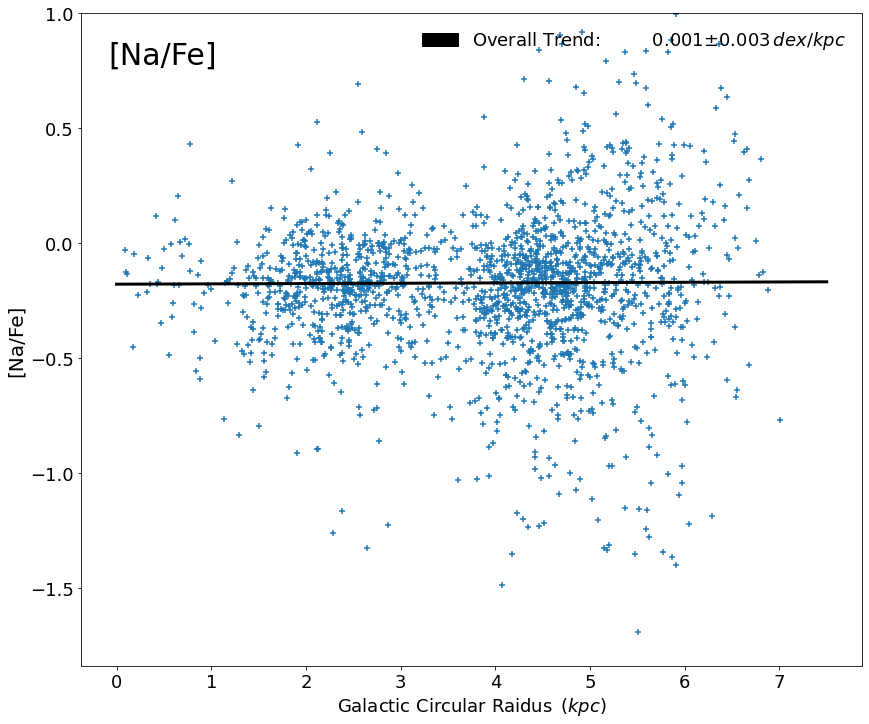

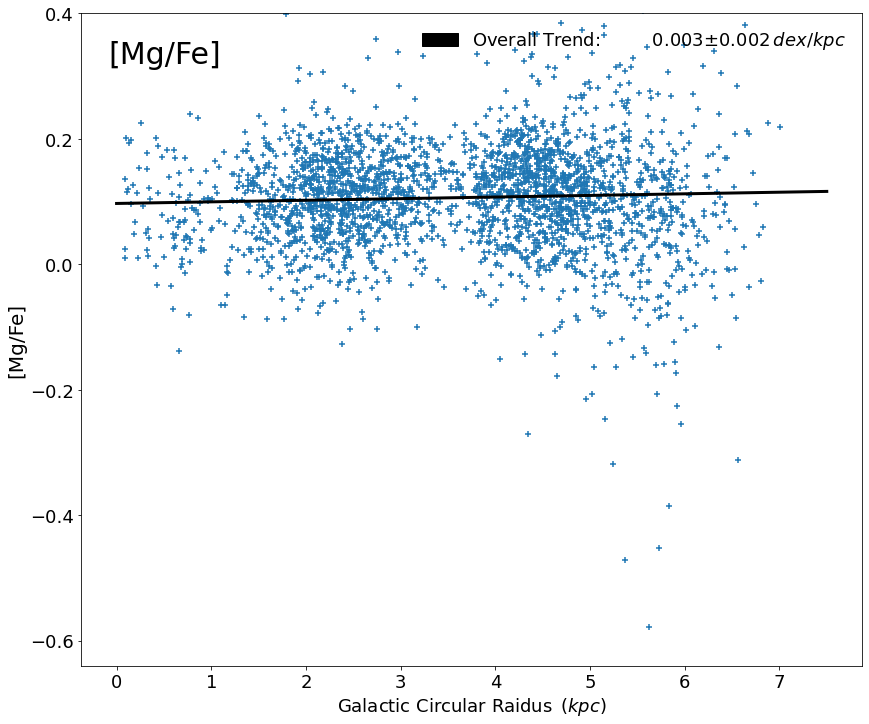

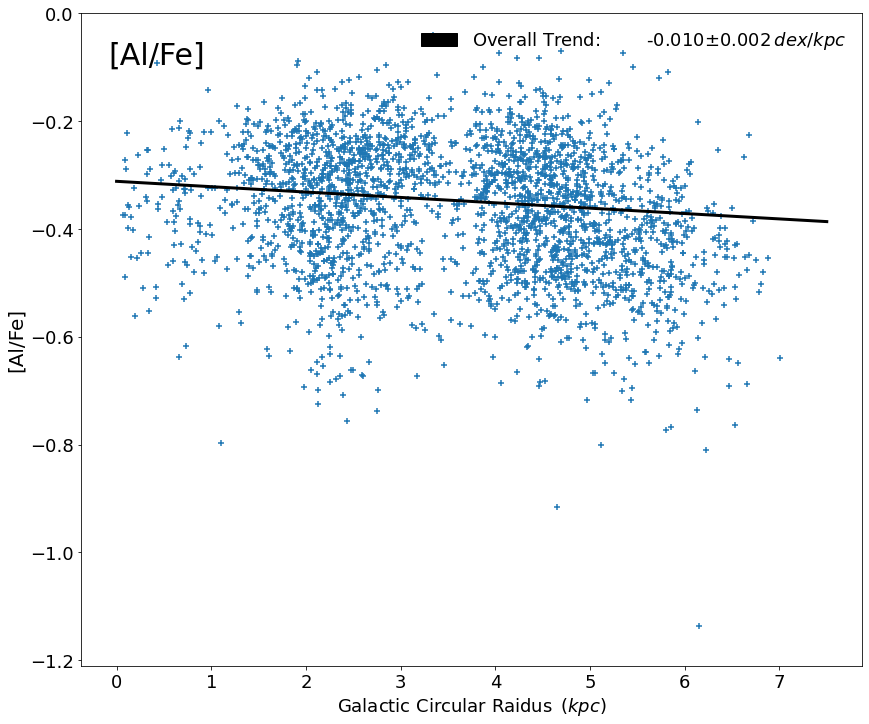

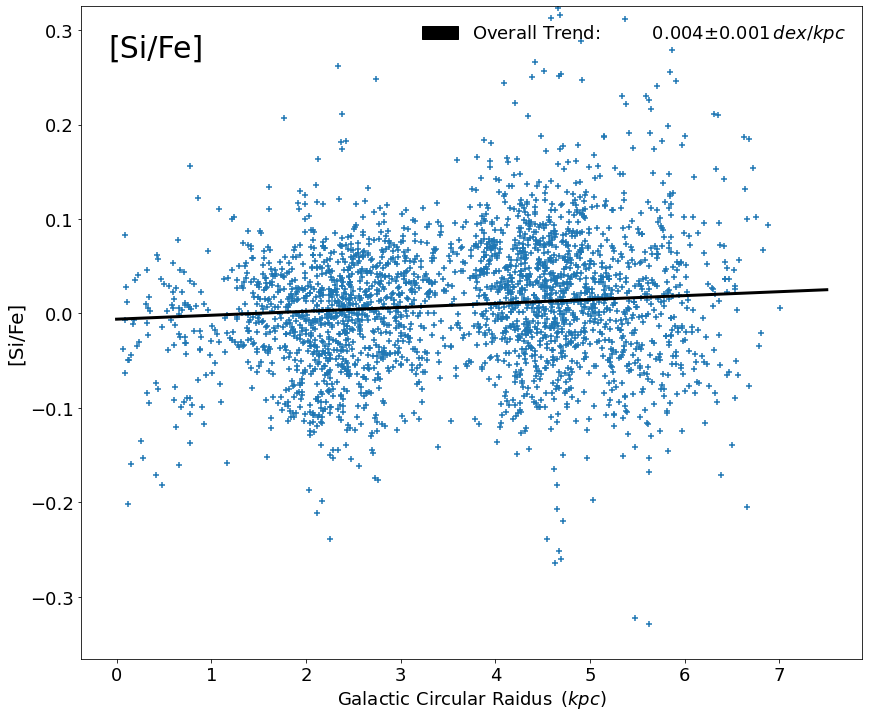

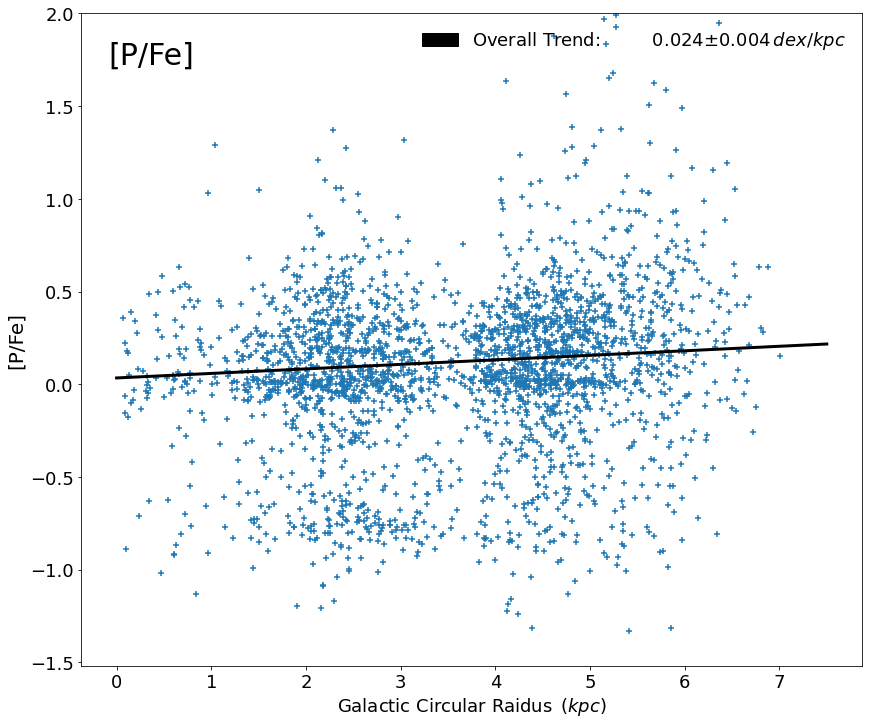

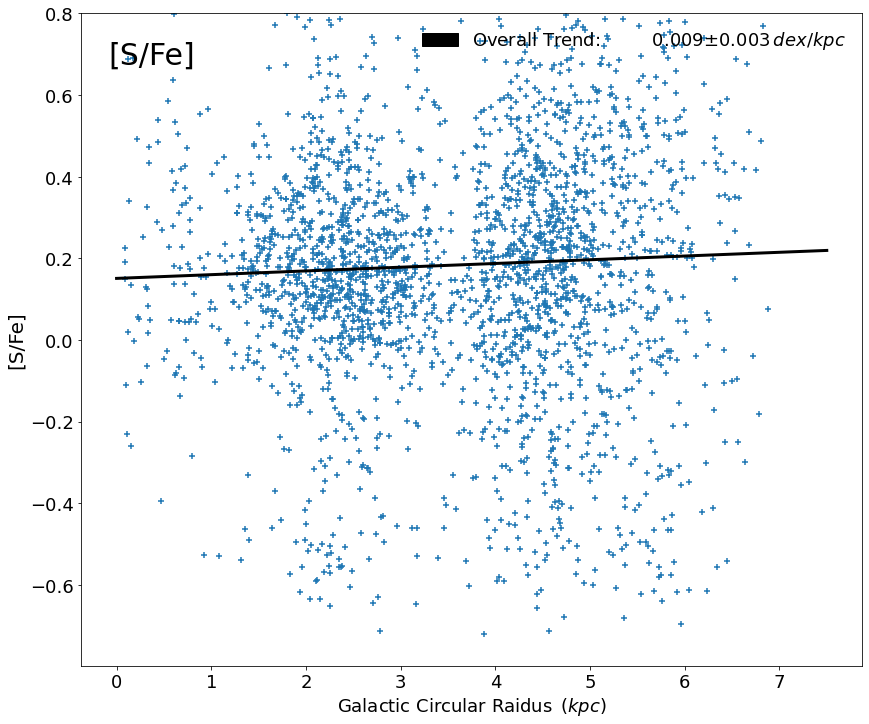

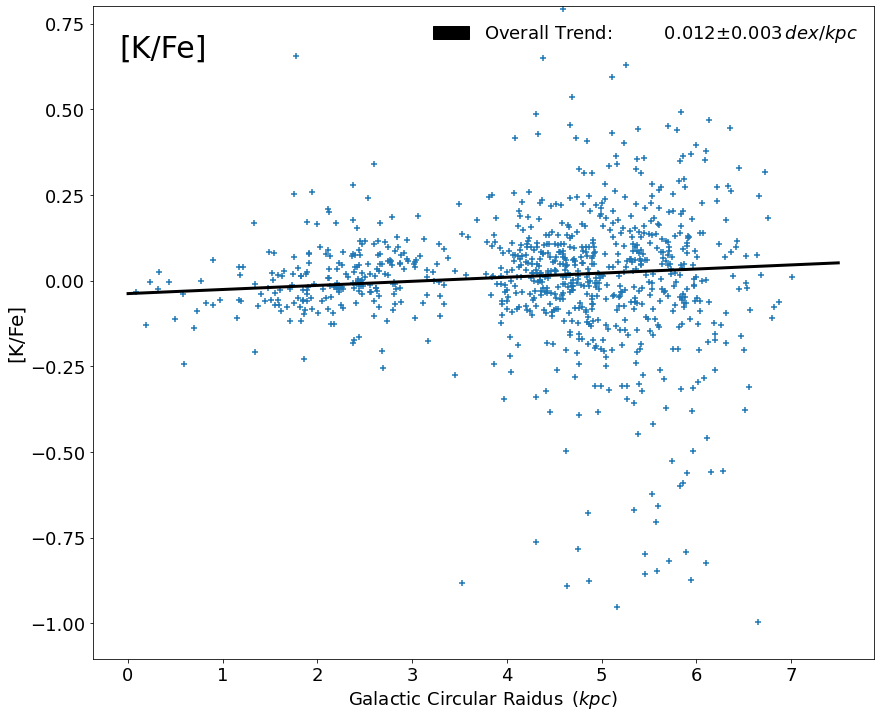

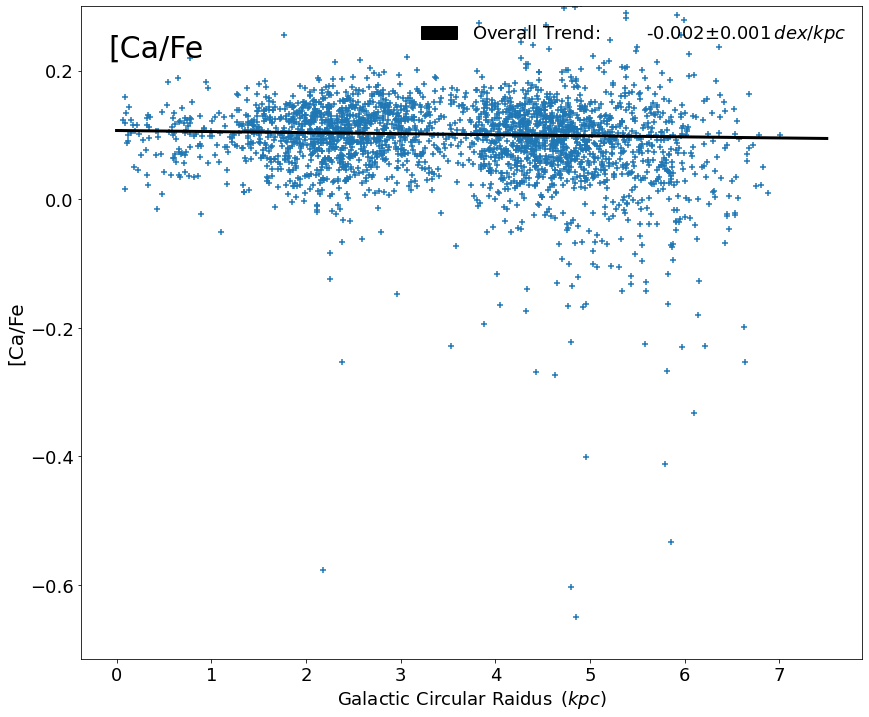

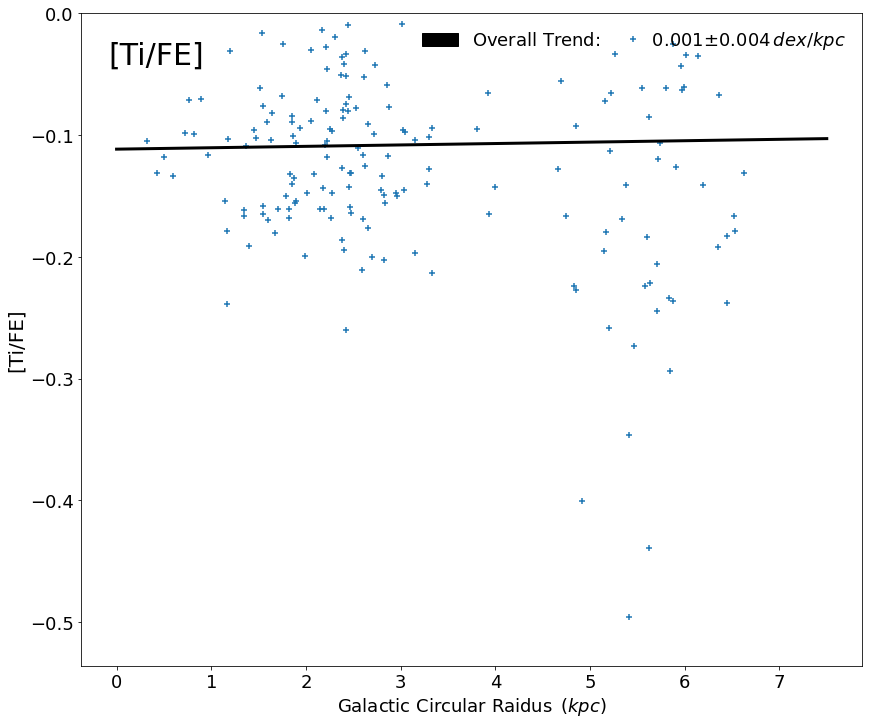

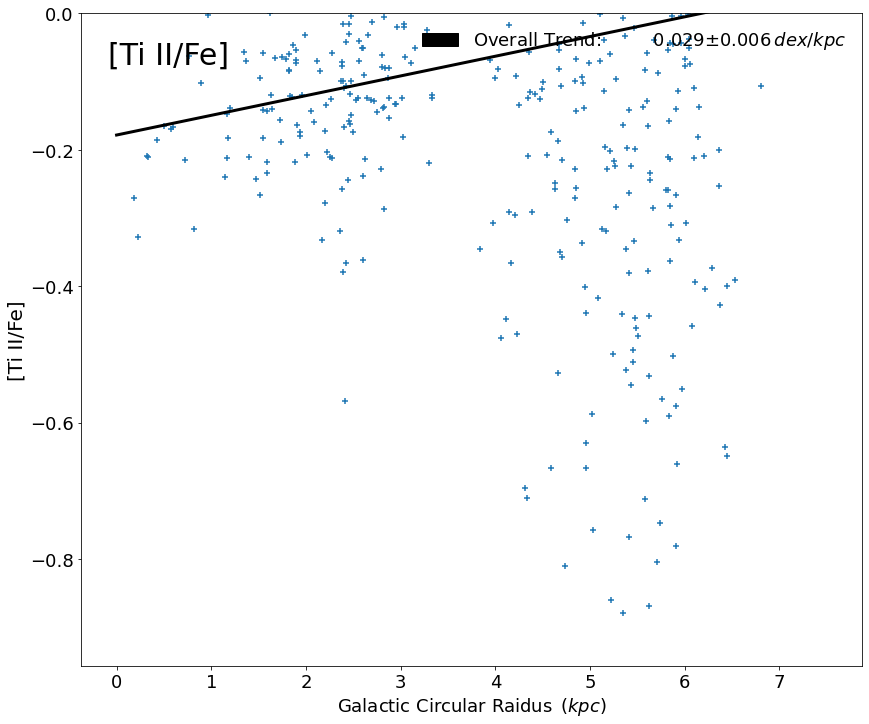

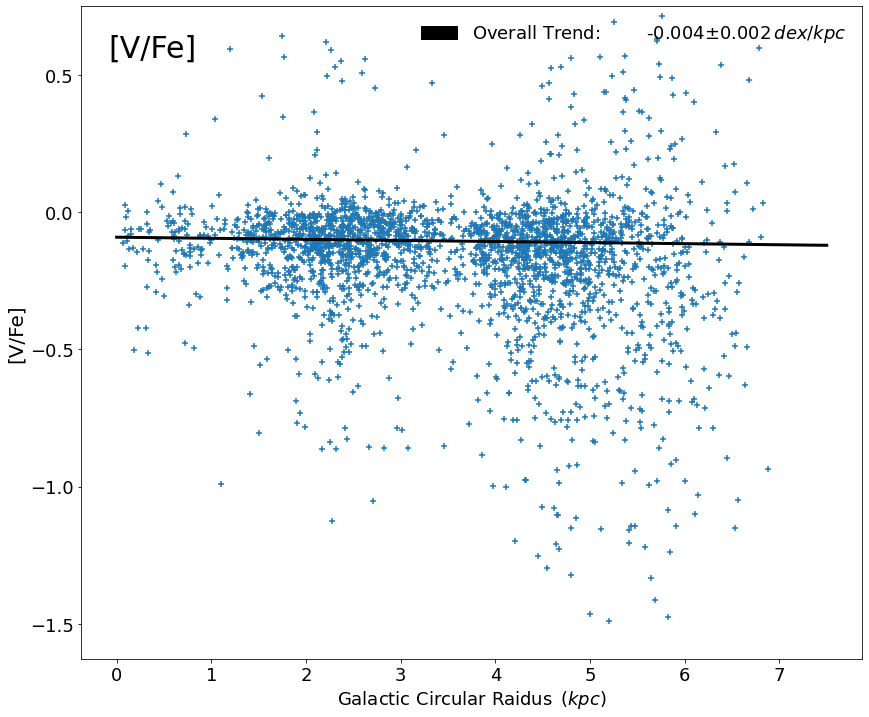

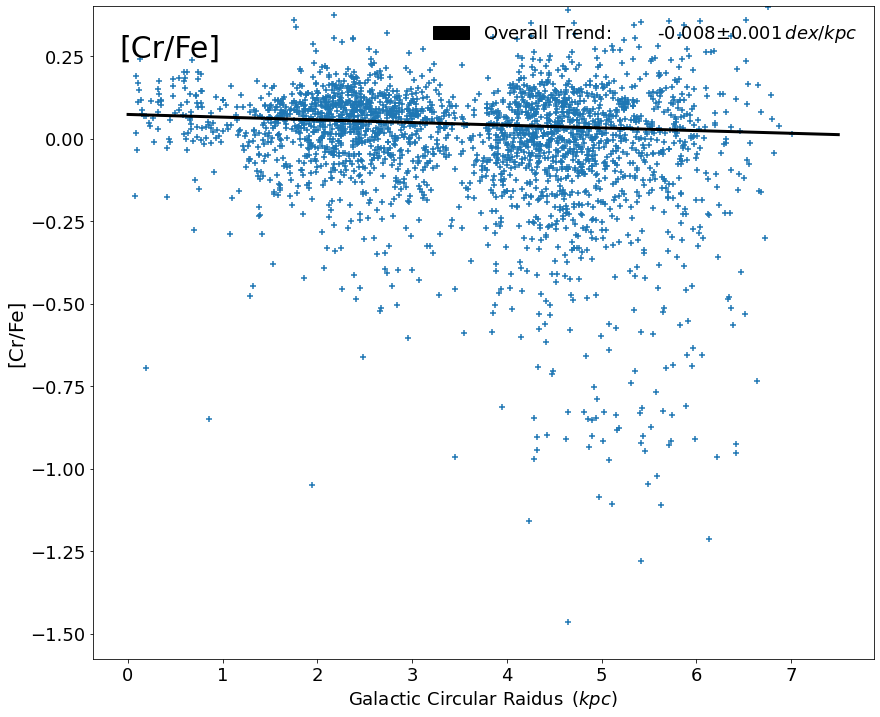

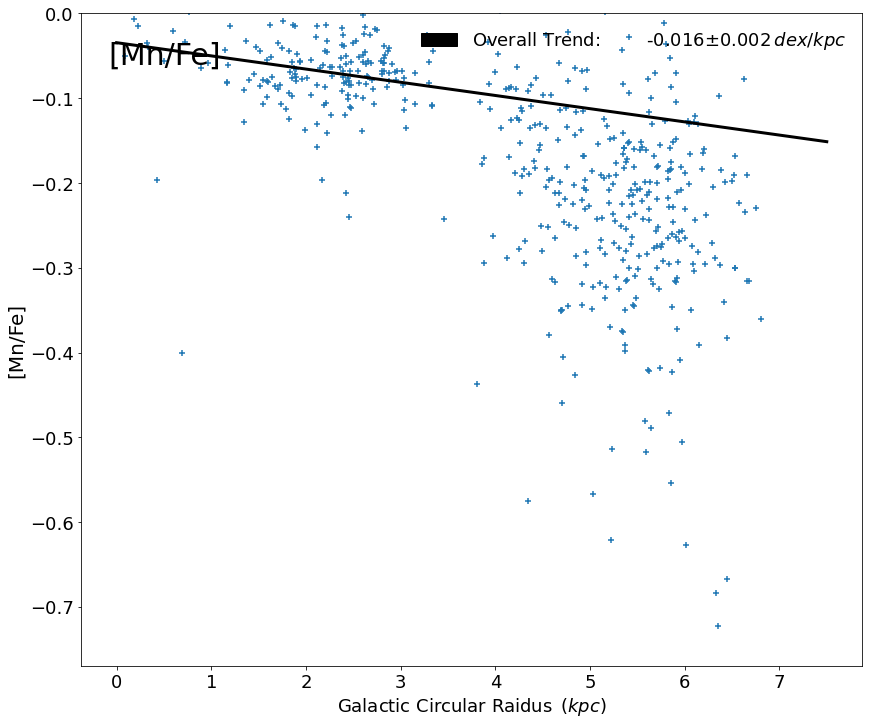

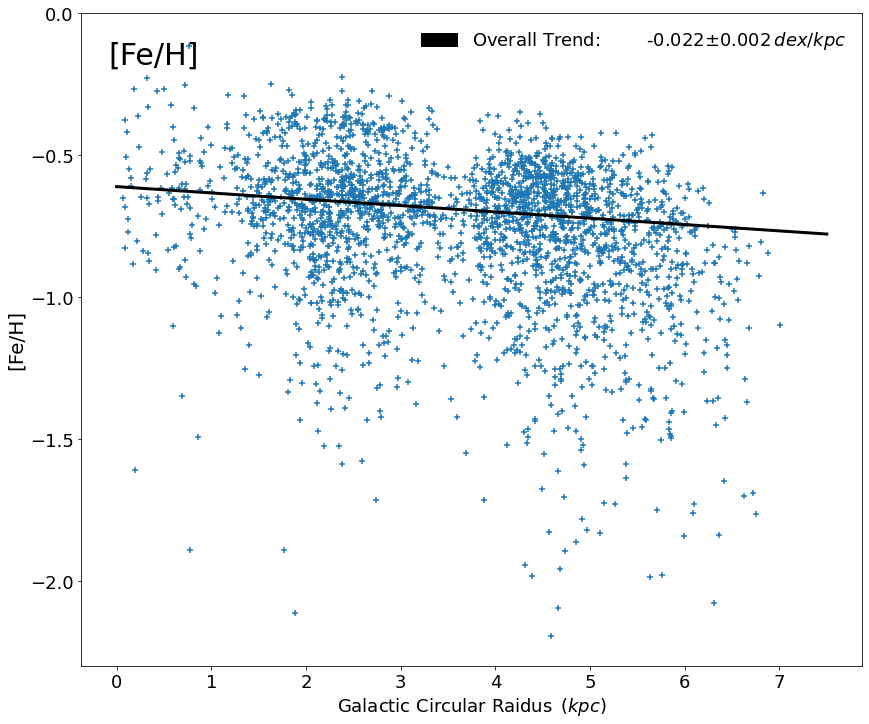

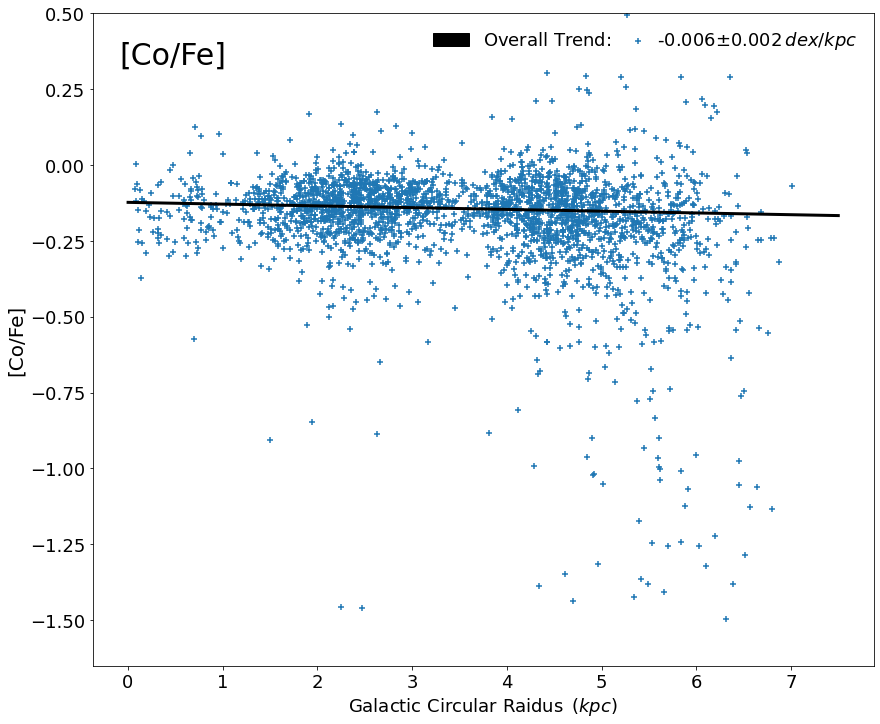

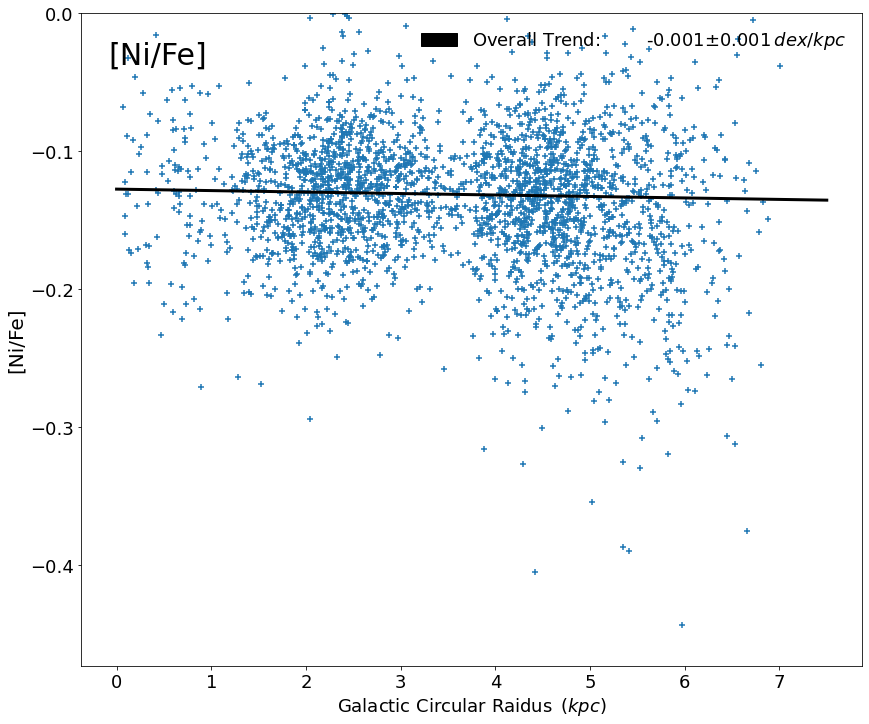

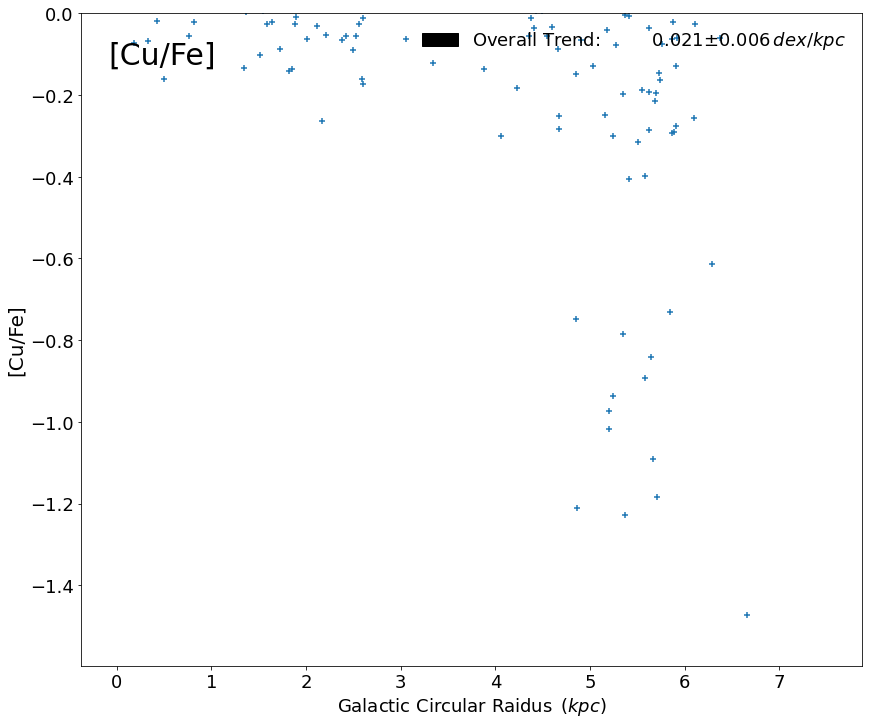

In [9]:
#####################################
### Overall Trend Plots with Data ###
#####################################

matplotlib.rcParams.update({'font.size': 18})

ytops = [0,0.1,0.7,0.2,1.0,0.4,0,0.325,2.0,0.8,0.8,0.3,0,0,0.75,0.4,0,0.0,0.5,0.0,0,0,0,0,0,0]

for i in tqdm_notebook(range(len(elems)-5),desc='plots',leave=False):
    
    cln = np.where(lmc[elems[i]]>-100)
    
    xval = np.linspace(0.0,7.5)

    fig = plt.figure(figsize=[14,12])
    
    ###Overall Trend
    def trendline(x):
        return re_med_ms[i]*x+re_med_bs[i]
    
    plt.plot(xval,trendline(xval),c='k',lw=3.0)
    plt.scatter(np.asarray(radius)[cln],lmc[elems[i]][cln],marker='+',c='tab:blue')
    
    handles,labels = plt.gca().get_legend_handles_labels()
    empty_over = mpatches.Patch(color='black',label='Overall Trend')
    handles.append(empty_over)

    labels.append('Overall Trend: {:>13.3f}$\pm {:.3f} \,dex/kpc$'.format(re_med_ms[i],med_m_devs[i]))
    
    plt.legend(handles,labels,loc='upper right',fontsize='medium',frameon=False)

    plt.ylabel(r'{}'.format(labs[i]),fontsize=20)
    plt.xlabel(r'Galactic Circular Raidus $\,(kpc$)')
    
    plt.ylim(top = ytops[i])
    
    
    ax0 = fig.add_subplot(111)
    at0 = AnchoredText('{}'.format(labs[i]),prop=dict(size=30),frameon=False,loc='upper left')
    at0.patch.set_boxstyle("square")
    ax0.add_artist(at0)
    
#     plt.savefig('overallgradonly{}.pdf'.format(elems[i]),bbox_inches='tight')
    plt.show()

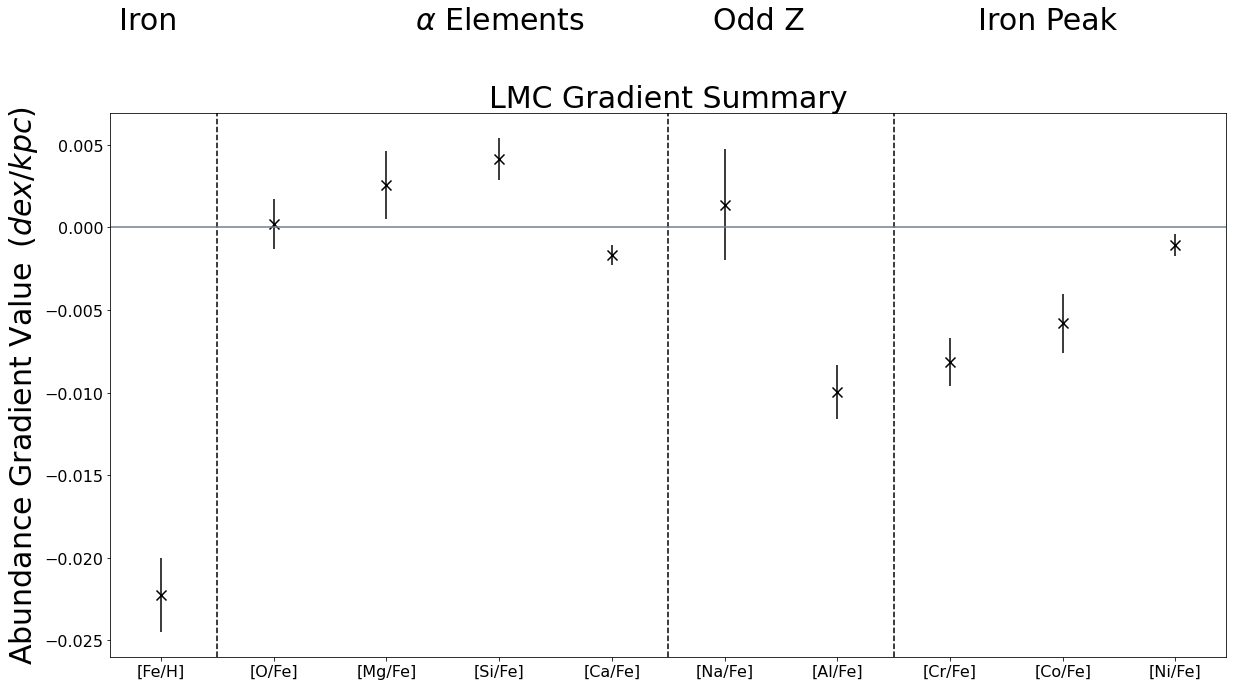

In [10]:
idx = [np.squeeze(np.where(np.asarray(elems)=='FE_H')),np.squeeze(np.where(np.asarray(elems)=='O_FE')),
       np.squeeze(np.where(np.asarray(elems)=='MG_FE')),np.squeeze(np.where(np.asarray(elems)=='SI_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CA_FE')),np.squeeze(np.where(np.asarray(elems)=='NA_FE')),
       np.squeeze(np.where(np.asarray(elems)=='AL_FE')),np.squeeze(np.where(np.asarray(elems)=='CR_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CO_FE')),np.squeeze(np.where(np.asarray(elems)=='NI_FE'))]

good_over = []
err_over = []

good_med = []
err_med = []

for i in idx:
    good_over.append(re_med_ms[i])
    err_over.append(med_m_devs[i])
    
#     good_med.append(med_m[i])

matplotlib.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=[20,10])

plt.scatter([0,1,2,3,4,5,6,7,8,9],good_over,marker='x',c='black',label='Overall',s=100)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_over,yerr=err_over,c='black',ls='none')

#plt.scatter([0,1,2,3,4,5,6,7,8,9],good_med,marker='x',c='red',label='0.5 kpc bins',s=100)

xplotlab = ['[Fe/H]','[O/Fe]','[Mg/Fe]','[Si/Fe]','[Ca/Fe]','[Na/Fe]','[Al/Fe]','[Cr/Fe]','[Co/Fe]','[Ni/Fe]']
xplotpos = [0,1,2,3,4,5,6,7,8,9] 
plt.xticks(xplotpos,xplotlab)

plt.axvline(0.5,c='k',ls='--')
plt.axvline(4.5,c='k',ls='--')
plt.axvline(6.5,c='k',ls='--')
plt.axhline(0.0,c='slategrey',ls='-')
plt.ylabel('Abundance Gradient Value $\,(dex/kpc)$',fontsize=30)

# plt.gca().set_ylim(top=0.05)

plt.text(-0.375,0.012,'Iron',fontsize=30)
plt.text(2.25,0.012,'$\\alpha$ Elements',fontsize=30)
plt.text(4.9,0.012,'Odd Z',fontsize=30)
plt.text(7.25,0.012,'Iron Peak',fontsize=30)

plt.title(r'LMC Gradient Summary',fontsize=30)

# plt.legend(loc='lower center',frameon=True,fancybox=False,fontsize='large')
# plt.savefig('mle_overall.pdf',bbox_inches='tight')
plt.show()

<font size='45'>
    <b>
        AGE BINS
    </b>
</font>

In [11]:
ages = fits.getdata('/Users/joshuapovick/Desktop/Research/LMC_Ages/Polynomial_LMC_Ages/pca_ols_sample.fits')
ages.columns

ColDefs(
    name = 'APOGEE_ID'; format = '18A'
    name = 'MAD_AGE'; format = 'D'
    name = 'MAD_AGE_ERR'; format = 'D'
    name = 'LL_AGE'; format = 'D'
    name = 'LL_AGE_ERR'; format = 'D'
    name = 'MAX_RESID_AGE'; format = 'D'
    name = 'MAX_RESID_AGE_ERR'; format = 'D'
    name = 'CURRENT_AGE'; format = 'D'
    name = 'CURRENT_AGE_ERR'; format = 'D'
    name = 'ALL_AGE'; format = 'D'
    name = 'ALL_AGE_ERR'; format = 'D'
)

In [12]:
#####################
### Make AGE Bins ###
#####################

### mad
youngmad = np.where(ages['MAD_AGE']<=np.log10(0.5*10**9))
ylessmad = np.where((ages['MAD_AGE']>np.log10(0.5*10**9))&(ages['MAD_AGE']<=np.log10(2.0*10**9)))
ymedmad = np.where((ages['MAD_AGE']>np.log10(2.0*10**9))&(ages['MAD_AGE']<=np.log10(7*10**9)))
omedmad = np.where((ages['MAD_AGE']>np.log10(7*10**9))&(ages['MAD_AGE']<=np.log10(10.5*10**9)))
oldmad = np.where(ages['MAD_AGE']>np.log10(10.5*10**9))

lmcyoungmad = lmc[youngmad]
lmcylessmad = lmc[ylessmad]
lmcymedmad = lmc[ymedmad]
lmcomedmad = lmc[omedmad]
lmcoldmad = lmc[oldmad]

### ll
youngll = np.where(ages['ll_AGE']<=np.log10(0.5*10**9))
ylessll = np.where((ages['ll_AGE']>np.log10(0.5*10**9))&(ages['ll_AGE']<=np.log10(2.0*10**9)))
ymedll = np.where((ages['ll_AGE']>np.log10(2.0*10**9))&(ages['ll_AGE']<=np.log10(7*10**9)))
omedll = np.where((ages['ll_AGE']>np.log10(7*10**9))&(ages['ll_AGE']<=np.log10(10.5*10**9)))
oldll = np.where(ages['ll_AGE']>np.log10(10.5*10**9))

lmcyoungll = lmc[youngll]
lmcylessll = lmc[ylessll]
lmcymedll = lmc[ymedll]
lmcomedll = lmc[omedll]
lmcoldll = lmc[oldll]

### max resid
youngmax = np.where(ages['MAX_RESID_AGE']<=np.log10(0.5*10**9))
ylessmax = np.where((ages['MAX_RESID_AGE']>np.log10(0.5*10**9))&(ages['MAX_RESID_AGE']<=np.log10(2.0*10**9)))
ymedmax = np.where((ages['MAX_RESID_AGE']>np.log10(2.0*10**9))&(ages['MAX_RESID_AGE']<=np.log10(7*10**9)))
omedmax = np.where((ages['MAX_RESID_AGE']>np.log10(7*10**9))&(ages['MAX_RESID_AGE']<=np.log10(10.5*10**9)))
oldmax = np.where(ages['MAX_RESID_AGE']>np.log10(10.5*10**9))

lmcyoungmax = lmc[youngmax]
lmcylessmax = lmc[ylessmax]
lmcymedmax = lmc[ymedmax]
lmcomedmax = lmc[omedmax]
lmcoldmax = lmc[oldmax]

### current
youngcur = np.where(ages['CURRENT_AGE']<=np.log10(0.5*10**9))
ylesscur = np.where((ages['CURRENT_AGE']>np.log10(0.5*10**9))&(ages['CURRENT_AGE']<=np.log10(2.0*10**9)))
ymedcur = np.where((ages['CURRENT_AGE']>np.log10(2.0*10**9))&(ages['CURRENT_AGE']<=np.log10(7*10**9)))
omedcur = np.where((ages['CURRENT_AGE']>np.log10(7*10**9))&(ages['CURRENT_AGE']<=np.log10(10.5*10**9)))
oldcur = np.where(ages['CURRENT_AGE']>np.log10(10.5*10**9))

lmcyoungcur = lmc[youngcur]
lmcylesscur = lmc[ylesscur]
lmcymedcur = lmc[ymedcur]
lmcomedcur = lmc[omedcur]
lmcoldcur = lmc[oldcur]

### all
youngall = np.where(ages['ALL_AGE']<=np.log10(0.5*10**9))
ylessall = np.where((ages['ALL_AGE']>np.log10(0.5*10**9))&(ages['ALL_AGE']<=np.log10(2.0*10**9)))
ymedall = np.where((ages['ALL_AGE']>np.log10(2.0*10**9))&(ages['ALL_AGE']<=np.log10(7*10**9)))
omedall = np.where((ages['ALL_AGE']>np.log10(7*10**9))&(ages['ALL_AGE']<=np.log10(10.5*10**9)))
oldall = np.where(ages['ALL_AGE']>np.log10(10.5*10**9))

lmcyoungall = lmc[youngall]
lmcylessall = lmc[ylessall]
lmcymedall = lmc[ymedall]
lmcomedall = lmc[omedall]
lmcoldall = lmc[oldall]

In [13]:
######################################
### Age bin initial Trendlines MAD ###
######################################

### youngmad

youngmad_ms = []
youngmad_bs = []

lmcyoungmad = lmc[youngmad]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((lmcyoungmad[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[youngmad][cln],lmcyoungmad[elems[i]][cln],lmcyoungmad[elems_err[i]][cln])
        youngmad_ms.append(slope)
        youngmad_bs.append(inter)
        
    except:
        youngmad_ms.append(-9999.0)
        youngmad_bs.append(-9999.0)
    
### ylessmad

ylessmad_ms = []
ylessmad_bs = []

lmcylessmad = lmc[ylessmad]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((lmcylessmad[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[ylessmad][cln],lmcylessmad[elems[i]][cln],lmcylessmad[elems_err[i]][cln])
        ylessmad_ms.append(slope)
        ylessmad_bs.append(inter)
        
    except:
        ylessmad_ms.append(-9999.0)
        ylessmad_bs.append(-9999.0)
    
### ymedmad

ymedmad_ms = []
ymedmad_bs = []

lmcymedmad = lmc[ymedmad]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((lmcymedmad[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[ymedmad][cln],lmcymedmad[elems[i]][cln],lmcymedmad[elems_err[i]][cln])
        ymedmad_ms.append(slope)
        ymedmad_bs.append(inter)
        
    except:
        ymedmad_ms.append(-9999.0)
        ymedmad_bs.append(-9999.0)
    
### omedmad

omedmad_ms = []
omedmad_bs = []

lmcomedmad = lmc[omedmad]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((lmcomedmad[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[omedmad][cln],lmcomedmad[elems[i]][cln],lmcomedmad[elems_err[i]][cln])
        omedmad_ms.append(slope)
        omedmad_bs.append(inter)
        
    except:
        omedmad_ms.append(-9999.0)
        omedmad_bs.append(-9999.0)
    
### oldmad

oldmad_ms = []
oldmad_bs = []

lmcoldmad = lmc[oldmad]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((lmcoldmad[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[oldmad][cln],lmcoldmad[elems[i]][cln],lmcoldmad[elems_err[i]][cln])
        oldmad_ms.append(slope)
        oldmad_bs.append(inter)
        
    except:
        oldmad_ms.append(-9999.0)
        oldmad_bs.append(-9999.0)

In [14]:
#####################################
### Age bin initial Trendlines ll ###
#####################################

### youngll

youngll_ms = []
youngll_bs = []

lmcyoungll = lmc[youngll]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((lmcyoungll[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[youngll][cln],lmcyoungll[elems[i]][cln],lmcyoungll[elems_err[i]][cln])
        youngll_ms.append(slope)
        youngll_bs.append(inter)
        
    except:
        youngll_ms.append(-9999.0)
        youngll_bs.append(-9999.0)
    
### ylessll

ylessll_ms = []
ylessll_bs = []

lmcylessll = lmc[ylessll]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((lmcylessll[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[ylessll][cln],lmcylessll[elems[i]][cln],lmcylessll[elems_err[i]][cln])
        ylessll_ms.append(slope)
        ylessll_bs.append(inter)
        
    except:
        ylessll_ms.append(-9999.0)
        ylessll_bs.append(-9999.0)
    
### ymedll

ymedll_ms = []
ymedll_bs = []

lmcymedll = lmc[ymedll]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((lmcymedll[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[ymedll][cln],lmcymedll[elems[i]][cln],lmcymedll[elems_err[i]][cln])
        ymedll_ms.append(slope)
        ymedll_bs.append(inter)
        
    except:
        ymedll_ms.append(-9999.0)
        ymedll_bs.append(-9999.0)
    
### omedll

omedll_ms = []
omedll_bs = []

lmcomedll = lmc[omedll]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((lmcomedll[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[omedll][cln],lmcomedll[elems[i]][cln],lmcomedll[elems_err[i]][cln])
        omedll_ms.append(slope)
        omedll_bs.append(inter)
        
    except:
        omedll_ms.append(-9999.0)
        omedll_bs.append(-9999.0)
    
### oldll

oldll_ms = []
oldll_bs = []

lmcoldll = lmc[oldll]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((lmcoldll[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[oldll][cln],lmcoldll[elems[i]][cln],lmcoldll[elems_err[i]][cln])
        oldll_ms.append(slope)
        oldll_bs.append(inter)
        
    except:
        oldll_ms.append(-9999.0)
        oldll_bs.append(-9999.0)

In [15]:
############################################
### Age bin initial Trendlines max resid ###
############################################

### youngmax

youngmax_ms = []
youngmax_bs = []

lmcyoungmax = lmc[youngmax]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((lmcyoungmax[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[youngmax][cln],lmcyoungmax[elems[i]][cln],lmcyoungmax[elems_err[i]][cln])
        youngmax_ms.append(slope)
        youngmax_bs.append(inter)
        
    except:
        youngmax_ms.append(-9999.0)
        youngmax_bs.append(-9999.0)
    
### ylessmax

ylessmax_ms = []
ylessmax_bs = []

lmcylessmax = lmc[ylessmax]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((lmcylessmax[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[ylessmax][cln],lmcylessmax[elems[i]][cln],lmcylessmax[elems_err[i]][cln])
        ylessmax_ms.append(slope)
        ylessmax_bs.append(inter)
        
    except:
        ylessmax_ms.append(-9999.0)
        ylessmax_bs.append(-9999.0)
    
### ymedmax

ymedmax_ms = []
ymedmax_bs = []

lmcymedmax = lmc[ymedmax]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((lmcymedmax[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[ymedmax][cln],lmcymedmax[elems[i]][cln],lmcymedmax[elems_err[i]][cln])
        ymedmax_ms.append(slope)
        ymedmax_bs.append(inter)
        
    except:
        ymedmax_ms.append(-9999.0)
        ymedmax_bs.append(-9999.0)
    
### omedmax

omedmax_ms = []
omedmax_bs = []

lmcomedmax = lmc[omedmax]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((lmcomedmax[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[omedmax][cln],lmcomedmax[elems[i]][cln],lmcomedmax[elems_err[i]][cln])
        omedmax_ms.append(slope)
        omedmax_bs.append(inter)
        
    except:
        omedmax_ms.append(-9999.0)
        omedmax_bs.append(-9999.0)
    
### oldmax

oldmax_ms = []
oldmax_bs = []

lmcoldmax = lmc[oldmax]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((lmcoldmax[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[oldmax][cln],lmcoldmax[elems[i]][cln],lmcoldmax[elems_err[i]][cln])
        oldmax_ms.append(slope)
        oldmax_bs.append(inter)
        
    except:
        oldmax_ms.append(-9999.0)
        oldmax_bs.append(-9999.0)

In [16]:
##########################################
### Age bin initial Trendlines current ###
##########################################

### youngcur

youngcur_ms = []
youngcur_bs = []

lmcyoungcur = lmc[youngcur]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((lmcyoungcur[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[youngcur][cln],lmcyoungcur[elems[i]][cln],lmcyoungcur[elems_err[i]][cln])
        youngcur_ms.append(slope)
        youngcur_bs.append(inter)
        
    except:
        youngcur_ms.append(-9999.0)
        youngcur_bs.append(-9999.0)
    
### ylesscur

ylesscur_ms = []
ylesscur_bs = []

lmcylesscur = lmc[ylesscur]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((lmcylesscur[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[ylesscur][cln],lmcylesscur[elems[i]][cln],lmcylesscur[elems_err[i]][cln])
        ylesscur_ms.append(slope)
        ylesscur_bs.append(inter)
        
    except:
        ylesscur_ms.append(-9999.0)
        ylesscur_bs.append(-9999.0)
    
### ymedcur

ymedcur_ms = []
ymedcur_bs = []

lmcymedcur = lmc[ymedcur]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((lmcymedcur[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[ymedcur][cln],lmcymedcur[elems[i]][cln],lmcymedcur[elems_err[i]][cln])
        ymedcur_ms.append(slope)
        ymedcur_bs.append(inter)
        
    except:
        ymedcur_ms.append(-9999.0)
        ymedcur_bs.append(-9999.0)
    
### omedcur

omedcur_ms = []
omedcur_bs = []

lmcomedcur = lmc[omedcur]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((lmcomedcur[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[omedcur][cln],lmcomedcur[elems[i]][cln],lmcomedcur[elems_err[i]][cln])
        omedcur_ms.append(slope)
        omedcur_bs.append(inter)
        
    except:
        omedcur_ms.append(-9999.0)
        omedcur_bs.append(-9999.0)
    
### oldcur

oldcur_ms = []
oldcur_bs = []

lmcoldcur = lmc[oldcur]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((lmcoldcur[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[oldcur][cln],lmcoldcur[elems[i]][cln],lmcoldcur[elems_err[i]][cln])
        oldcur_ms.append(slope)
        oldcur_bs.append(inter)
        
    except:
        oldcur_ms.append(-9999.0)
        oldcur_bs.append(-9999.0)

In [17]:
#####################################
### Age bin initial Trendlines all ###
#####################################

### youngall

youngall_ms = []
youngall_bs = []

lmcyoungall = lmc[youngall]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((lmcyoungall[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[youngall][cln],lmcyoungall[elems[i]][cln],lmcyoungall[elems_err[i]][cln])
        youngall_ms.append(slope)
        youngall_bs.append(inter)
        
    except:
        youngall_ms.append(-9999.0)
        youngall_bs.append(-9999.0)
    
### ylessall

ylessall_ms = []
ylessall_bs = []

lmcylessall = lmc[ylessall]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((lmcylessall[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[ylessall][cln],lmcylessall[elems[i]][cln],lmcylessall[elems_err[i]][cln])
        ylessall_ms.append(slope)
        ylessall_bs.append(inter)
        
    except:
        ylessall_ms.append(-9999.0)
        ylessall_bs.append(-9999.0)
    
### ymedall

ymedall_ms = []
ymedall_bs = []

lmcymedall = lmc[ymedall]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((lmcymedall[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[ymedall][cln],lmcymedall[elems[i]][cln],lmcymedall[elems_err[i]][cln])
        ymedall_ms.append(slope)
        ymedall_bs.append(inter)
        
    except:
        ymedall_ms.append(-9999.0)
        ymedall_bs.append(-9999.0)
    
### omedall

omedall_ms = []
omedall_bs = []

lmcomedall = lmc[omedall]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((lmcomedall[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[omedall][cln],lmcomedall[elems[i]][cln],lmcomedall[elems_err[i]][cln])
        omedall_ms.append(slope)
        omedall_bs.append(inter)
        
    except:
        omedall_ms.append(-9999.0)
        omedall_bs.append(-9999.0)
    
### oldall

oldall_ms = []
oldall_bs = []

lmcoldall = lmc[oldall]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((lmcoldall[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[oldall][cln],lmcoldall[elems[i]][cln],lmcoldall[elems_err[i]][cln])
        oldall_ms.append(slope)
        oldall_bs.append(inter)
        
    except:
        oldall_ms.append(-9999.0)
        oldall_bs.append(-9999.0)

In [18]:
###############################################
### Find distances between data and fits mad ###
###############################################

youngmad_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return youngmad_ms[i]*x+youngmad_bs[i]
    
    cln = np.where((lmcyoungmad[elems[i]]>-100))
    plug = trendline(radius[youngmad][cln])
    dist = plug-lmcyoungmad[elems[i]][cln]
    
    youngmad_dist.append(dist) 
    
ylessmad_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return ylessmad_ms[i]*x+ylessmad_bs[i]
    
    cln = np.where((lmcylessmad[elems[i]]>-100))
    plug = trendline(radius[ylessmad][cln])
    dist = plug-lmcylessmad[elems[i]][cln]
    
    ylessmad_dist.append(dist) 
    
ymedmad_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return ymedmad_ms[i]*x+ymedmad_bs[i]
    
    cln = np.where((lmcymedmad[elems[i]]>-100))
    plug = trendline(radius[ymedmad][cln])
    dist = plug-lmcymedmad[elems[i]][cln]
    
    ymedmad_dist.append(dist) 
    
omedmad_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return omedmad_ms[i]*x+omedmad_bs[i]
    
    cln = np.where((lmcomedmad[elems[i]]>-100))
    plug = trendline(radius[omedmad][cln])
    dist = plug-lmcomedmad[elems[i]][cln]
    
    omedmad_dist.append(dist) 
    
oldmad_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return oldmad_ms[i]*x+oldmad_bs[i]
    
    cln = np.where((lmcoldmad[elems[i]]>-100))
    plug = trendline(radius[oldmad][cln])
    dist = plug-lmcoldmad[elems[i]][cln]
    
    oldmad_dist.append(dist)

In [19]:
###############################################
### Find distances between data and fits ll ###
###############################################

youngll_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return youngll_ms[i]*x+youngll_bs[i]
    
    cln = np.where((lmcyoungll[elems[i]]>-100))
    plug = trendline(radius[youngll][cln])
    dist = plug-lmcyoungll[elems[i]][cln]
    
    youngll_dist.append(dist) 
    
ylessll_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return ylessll_ms[i]*x+ylessll_bs[i]
    
    cln = np.where((lmcylessll[elems[i]]>-100))
    plug = trendline(radius[ylessll][cln])
    dist = plug-lmcylessll[elems[i]][cln]
    
    ylessll_dist.append(dist) 
    
ymedll_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return ymedll_ms[i]*x+ymedll_bs[i]
    
    cln = np.where((lmcymedll[elems[i]]>-100))
    plug = trendline(radius[ymedll][cln])
    dist = plug-lmcymedll[elems[i]][cln]
    
    ymedll_dist.append(dist) 
    
omedll_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return omedll_ms[i]*x+omedll_bs[i]
    
    cln = np.where((lmcomedll[elems[i]]>-100))
    plug = trendline(radius[omedll][cln])
    dist = plug-lmcomedll[elems[i]][cln]
    
    omedll_dist.append(dist) 
    
oldll_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return oldll_ms[i]*x+oldll_bs[i]
    
    cln = np.where((lmcoldll[elems[i]]>-100))
    plug = trendline(radius[oldll][cln])
    dist = plug-lmcoldll[elems[i]][cln]
    
    oldll_dist.append(dist)

In [20]:
###############################################
### Find distances between data and fits max ###
###############################################

youngmax_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return youngmax_ms[i]*x+youngmax_bs[i]
    
    cln = np.where((lmcyoungmax[elems[i]]>-100))
    plug = trendline(radius[youngmax][cln])
    dist = plug-lmcyoungmax[elems[i]][cln]
    
    youngmax_dist.append(dist) 
    
ylessmax_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return ylessmax_ms[i]*x+ylessmax_bs[i]
    
    cln = np.where((lmcylessmax[elems[i]]>-100))
    plug = trendline(radius[ylessmax][cln])
    dist = plug-lmcylessmax[elems[i]][cln]
    
    ylessmax_dist.append(dist) 
    
ymedmax_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return ymedmax_ms[i]*x+ymedmax_bs[i]
    
    cln = np.where((lmcymedmax[elems[i]]>-100))
    plug = trendline(radius[ymedmax][cln])
    dist = plug-lmcymedmax[elems[i]][cln]
    
    ymedmax_dist.append(dist) 
    
omedmax_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return omedmax_ms[i]*x+omedmax_bs[i]
    
    cln = np.where((lmcomedmax[elems[i]]>-100))
    plug = trendline(radius[omedmax][cln])
    dist = plug-lmcomedmax[elems[i]][cln]
    
    omedmax_dist.append(dist) 
    
oldmax_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return oldmax_ms[i]*x+oldmax_bs[i]
    
    cln = np.where((lmcoldmax[elems[i]]>-100))
    plug = trendline(radius[oldmax][cln])
    dist = plug-lmcoldmax[elems[i]][cln]
    
    oldmax_dist.append(dist)

In [21]:
###############################################
### Find distances between data and fits cur ###
###############################################

youngcur_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return youngcur_ms[i]*x+youngcur_bs[i]
    
    cln = np.where((lmcyoungcur[elems[i]]>-100))
    plug = trendline(radius[youngcur][cln])
    dist = plug-lmcyoungcur[elems[i]][cln]
    
    youngcur_dist.append(dist) 
    
ylesscur_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return ylesscur_ms[i]*x+ylesscur_bs[i]
    
    cln = np.where((lmcylesscur[elems[i]]>-100))
    plug = trendline(radius[ylesscur][cln])
    dist = plug-lmcylesscur[elems[i]][cln]
    
    ylesscur_dist.append(dist) 
    
ymedcur_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return ymedcur_ms[i]*x+ymedcur_bs[i]
    
    cln = np.where((lmcymedcur[elems[i]]>-100))
    plug = trendline(radius[ymedcur][cln])
    dist = plug-lmcymedcur[elems[i]][cln]
    
    ymedcur_dist.append(dist) 
    
omedcur_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return omedcur_ms[i]*x+omedcur_bs[i]
    
    cln = np.where((lmcomedcur[elems[i]]>-100))
    plug = trendline(radius[omedcur][cln])
    dist = plug-lmcomedcur[elems[i]][cln]
    
    omedcur_dist.append(dist) 
    
oldcur_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return oldcur_ms[i]*x+oldcur_bs[i]
    
    cln = np.where((lmcoldcur[elems[i]]>-100))
    plug = trendline(radius[oldcur][cln])
    dist = plug-lmcoldcur[elems[i]][cln]
    
    oldcur_dist.append(dist)

In [22]:
###############################################
### Find distances between data and fits all ###
###############################################

youngall_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return youngall_ms[i]*x+youngall_bs[i]
    
    cln = np.where((lmcyoungall[elems[i]]>-100))
    plug = trendline(radius[youngall][cln])
    dist = plug-lmcyoungall[elems[i]][cln]
    
    youngall_dist.append(dist) 
    
ylessall_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return ylessall_ms[i]*x+ylessall_bs[i]
    
    cln = np.where((lmcylessall[elems[i]]>-100))
    plug = trendline(radius[ylessall][cln])
    dist = plug-lmcylessall[elems[i]][cln]
    
    ylessall_dist.append(dist) 
    
ymedall_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return ymedall_ms[i]*x+ymedall_bs[i]
    
    cln = np.where((lmcymedall[elems[i]]>-100))
    plug = trendline(radius[ymedall][cln])
    dist = plug-lmcymedall[elems[i]][cln]
    
    ymedall_dist.append(dist) 
    
omedall_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return omedall_ms[i]*x+omedall_bs[i]
    
    cln = np.where((lmcomedall[elems[i]]>-100))
    plug = trendline(radius[omedall][cln])
    dist = plug-lmcomedall[elems[i]][cln]
    
    omedall_dist.append(dist) 
    
oldall_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return oldall_ms[i]*x+oldall_bs[i]
    
    cln = np.where((lmcoldall[elems[i]]>-100))
    plug = trendline(radius[oldall][cln])
    dist = plug-lmcoldall[elems[i]][cln]
    
    oldall_dist.append(dist)

In [23]:
###################
### Prune Refit ###
###################

prune_fact = 3.0

re_youngmad_ms = []
re_youngmad_bs = []
youngmad_m_devs = []
youngmad_b_devs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((lmcyoungmad[elems[i]]>-100))
    prune = np.where((lmcyoungmad[elems[i]]>-prune_fact*util.mad(youngmad_dist[i])+
                      np.median(lmcyoungmad[cln][elems[i]]))&
                     (lmcyoungmad[elems[i]]<prune_fact*util.mad(youngmad_dist[i])+
                      np.median(lmcyoungmad[cln][elems[i]])))

    exog = radius[youngmad][prune]
    endog = lmcyoungmad[elems[i]][prune]
    endog_err = lmcyoungmad[elems_err[i]][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    youngmad_m_devs.append(util.mad(slps))
    youngmad_b_devs.append(util.mad(ints))
    re_youngmad_ms.append(np.median(slps))
    re_youngmad_bs.append(np.median(ints))

re_ylessmad_ms = []
re_ylessmad_bs = []
ylessmad_m_devs = []
ylessmad_b_devs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((lmcylessmad[elems[i]]>-100))
    prune = np.where((lmcylessmad[elems[i]]>-prune_fact*util.mad(ylessmad_dist[i])+
                      np.median(lmcylessmad[cln][elems[i]]))&
                     (lmcylessmad[elems[i]]<prune_fact*util.mad(ylessmad_dist[i])+
                      np.median(lmcylessmad[cln][elems[i]])))

    exog = radius[ylessmad][prune]
    endog = lmcylessmad[elems[i]][prune]
    endog_err = lmcylessmad[elems_err[i]][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    ylessmad_m_devs.append(util.mad(slps))
    ylessmad_b_devs.append(util.mad(ints))
    re_ylessmad_ms.append(np.median(slps))
    re_ylessmad_bs.append(np.median(ints))

re_ymedmad_ms = []
re_ymedmad_bs = []
ymedmad_m_devs = []
ymedmad_b_devs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((lmcymedmad[elems[i]]>-100))
    prune = np.where((lmcymedmad[elems[i]]>-prune_fact*util.mad(ymedmad_dist[i])+
                      np.median(lmcymedmad[cln][elems[i]]))&
                     (lmcymedmad[elems[i]]<prune_fact*util.mad(ymedmad_dist[i])+
                      np.median(lmcymedmad[cln][elems[i]])))

    exog = radius[ymedmad][prune]
    endog = lmcymedmad[elems[i]][prune]
    endog_err = lmcymedmad[elems_err[i]][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    ymedmad_m_devs.append(util.mad(slps))
    ymedmad_b_devs.append(util.mad(ints))
    re_ymedmad_ms.append(np.median(slps))
    re_ymedmad_bs.append(np.median(ints))

re_omedmad_ms = []
re_omedmad_bs = []
omedmad_m_devs = []
omedmad_b_devs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((lmcomedmad[elems[i]]>-100))
    prune = np.where((lmcomedmad[elems[i]]>-prune_fact*util.mad(omedmad_dist[i])+
                      np.median(lmcomedmad[cln][elems[i]]))&
                     (lmcomedmad[elems[i]]<prune_fact*util.mad(omedmad_dist[i])+
                      np.median(lmcomedmad[cln][elems[i]])))

    exog = radius[omedmad][prune]
    endog = lmcomedmad[elems[i]][prune]
    endog_err = lmcomedmad[elems_err[i]][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    omedmad_m_devs.append(util.mad(slps))
    omedmad_b_devs.append(util.mad(ints))
    re_omedmad_ms.append(np.median(slps))
    re_omedmad_bs.append(np.median(ints))
    
re_oldmad_ms = []
re_oldmad_bs = []
oldmad_m_devs = []
oldmad_b_devs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((lmcoldmad[elems[i]]>-100))
    prune = np.where((lmcoldmad[elems[i]]>-prune_fact*util.mad(oldmad_dist[i])+
                      np.median(lmcoldmad[cln][elems[i]]))&
                     (lmcoldmad[elems[i]]<prune_fact*util.mad(oldmad_dist[i])+
                      np.median(lmcoldmad[cln][elems[i]])))

    exog = radius[oldmad][prune]
    endog = lmcoldmad[elems[i]][prune]
    endog_err = lmcoldmad[elems_err[i]][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    oldmad_m_devs.append(util.mad(slps))
    oldmad_b_devs.append(util.mad(ints))
    re_oldmad_ms.append(np.median(slps))
    re_oldmad_bs.append(np.median(ints))

In [24]:
###################
### Prune Refit ###
###################

prune_fact = 3.0

re_youngll_ms = []
re_youngll_bs = []
youngll_m_devs = []
youngll_b_devs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((lmcyoungll[elems[i]]>-100))
    prune = np.where((lmcyoungll[elems[i]]>-prune_fact*util.mad(youngll_dist[i])+
                      np.median(lmcyoungll[cln][elems[i]]))&
                     (lmcyoungll[elems[i]]<prune_fact*util.mad(youngll_dist[i])+
                      np.median(lmcyoungll[cln][elems[i]])))

    exog = radius[youngll][prune]
    endog = lmcyoungll[elems[i]][prune]
    endog_err = lmcyoungll[elems_err[i]][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    youngll_m_devs.append(util.mad(slps))
    youngll_b_devs.append(util.mad(ints))
    re_youngll_ms.append(np.median(slps))
    re_youngll_bs.append(np.median(ints))

re_ylessll_ms = []
re_ylessll_bs = []
ylessll_m_devs = []
ylessll_b_devs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((lmcylessll[elems[i]]>-100))
    prune = np.where((lmcylessll[elems[i]]>-prune_fact*util.mad(ylessll_dist[i])+
                      np.median(lmcylessll[cln][elems[i]]))&
                     (lmcylessll[elems[i]]<prune_fact*util.mad(ylessll_dist[i])+
                      np.median(lmcylessll[cln][elems[i]])))

    exog = radius[ylessll][prune]
    endog = lmcylessll[elems[i]][prune]
    endog_err = lmcylessll[elems_err[i]][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    ylessll_m_devs.append(util.mad(slps))
    ylessll_b_devs.append(util.mad(ints))
    re_ylessll_ms.append(np.median(slps))
    re_ylessll_bs.append(np.median(ints))

re_ymedll_ms = []
re_ymedll_bs = []
ymedll_m_devs = []
ymedll_b_devs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((lmcymedll[elems[i]]>-100))
    prune = np.where((lmcymedll[elems[i]]>-prune_fact*util.mad(ymedll_dist[i])+
                      np.median(lmcymedll[cln][elems[i]]))&
                     (lmcymedll[elems[i]]<prune_fact*util.mad(ymedll_dist[i])+
                      np.median(lmcymedll[cln][elems[i]])))

    exog = radius[ymedll][prune]
    endog = lmcymedll[elems[i]][prune]
    endog_err = lmcymedll[elems_err[i]][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    ymedll_m_devs.append(util.mad(slps))
    ymedll_b_devs.append(util.mad(ints))
    re_ymedll_ms.append(np.median(slps))
    re_ymedll_bs.append(np.median(ints))

re_omedll_ms = []
re_omedll_bs = []
omedll_m_devs = []
omedll_b_devs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((lmcomedll[elems[i]]>-100))
    prune = np.where((lmcomedll[elems[i]]>-prune_fact*util.mad(omedll_dist[i])+
                      np.median(lmcomedll[cln][elems[i]]))&
                     (lmcomedll[elems[i]]<prune_fact*util.mad(omedll_dist[i])+
                      np.median(lmcomedll[cln][elems[i]])))

    exog = radius[omedll][prune]
    endog = lmcomedll[elems[i]][prune]
    endog_err = lmcomedll[elems_err[i]][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    omedll_m_devs.append(util.mad(slps))
    omedll_b_devs.append(util.mad(ints))
    re_omedll_ms.append(np.median(slps))
    re_omedll_bs.append(np.median(ints))
    
re_oldll_ms = []
re_oldll_bs = []
oldll_m_devs = []
oldll_b_devs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((lmcoldll[elems[i]]>-100))
    prune = np.where((lmcoldll[elems[i]]>-prune_fact*util.mad(oldll_dist[i])+
                      np.median(lmcoldll[cln][elems[i]]))&
                     (lmcoldll[elems[i]]<prune_fact*util.mad(oldll_dist[i])+
                      np.median(lmcoldll[cln][elems[i]])))

    exog = radius[oldll][prune]
    endog = lmcoldll[elems[i]][prune]
    endog_err = lmcoldll[elems_err[i]][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    oldll_m_devs.append(util.mad(slps))
    oldll_b_devs.append(util.mad(ints))
    re_oldll_ms.append(np.median(slps))
    re_oldll_bs.append(np.median(ints))

In [25]:
###################
### Prune Refit ###
###################

prune_fact = 3.0

re_youngmax_ms = []
re_youngmax_bs = []
youngmax_m_devs = []
youngmax_b_devs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((lmcyoungmax[elems[i]]>-100))
    prune = np.where((lmcyoungmax[elems[i]]>-prune_fact*util.mad(youngmax_dist[i])+
                      np.median(lmcyoungmax[cln][elems[i]]))&
                     (lmcyoungmax[elems[i]]<prune_fact*util.mad(youngmax_dist[i])+
                      np.median(lmcyoungmax[cln][elems[i]])))

    exog = radius[youngmax][prune]
    endog = lmcyoungmax[elems[i]][prune]
    endog_err = lmcyoungmax[elems_err[i]][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    youngmax_m_devs.append(util.mad(slps))
    youngmax_b_devs.append(util.mad(ints))
    re_youngmax_ms.append(np.median(slps))
    re_youngmax_bs.append(np.median(ints))

re_ylessmax_ms = []
re_ylessmax_bs = []
ylessmax_m_devs = []
ylessmax_b_devs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((lmcylessmax[elems[i]]>-100))
    prune = np.where((lmcylessmax[elems[i]]>-prune_fact*util.mad(ylessmax_dist[i])+
                      np.median(lmcylessmax[cln][elems[i]]))&
                     (lmcylessmax[elems[i]]<prune_fact*util.mad(ylessmax_dist[i])+
                      np.median(lmcylessmax[cln][elems[i]])))

    exog = radius[ylessmax][prune]
    endog = lmcylessmax[elems[i]][prune]
    endog_err = lmcylessmax[elems_err[i]][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    ylessmax_m_devs.append(util.mad(slps))
    ylessmax_b_devs.append(util.mad(ints))
    re_ylessmax_ms.append(np.median(slps))
    re_ylessmax_bs.append(np.median(ints))

re_ymedmax_ms = []
re_ymedmax_bs = []
ymedmax_m_devs = []
ymedmax_b_devs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((lmcymedmax[elems[i]]>-100))
    prune = np.where((lmcymedmax[elems[i]]>-prune_fact*util.mad(ymedmax_dist[i])+
                      np.median(lmcymedmax[cln][elems[i]]))&
                     (lmcymedmax[elems[i]]<prune_fact*util.mad(ymedmax_dist[i])+
                      np.median(lmcymedmax[cln][elems[i]])))

    exog = radius[ymedmax][prune]
    endog = lmcymedmax[elems[i]][prune]
    endog_err = lmcymedmax[elems_err[i]][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    ymedmax_m_devs.append(util.mad(slps))
    ymedmax_b_devs.append(util.mad(ints))
    re_ymedmax_ms.append(np.median(slps))
    re_ymedmax_bs.append(np.median(ints))

re_omedmax_ms = []
re_omedmax_bs = []
omedmax_m_devs = []
omedmax_b_devs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((lmcomedmax[elems[i]]>-100))
    prune = np.where((lmcomedmax[elems[i]]>-prune_fact*util.mad(omedmax_dist[i])+
                      np.median(lmcomedmax[cln][elems[i]]))&
                     (lmcomedmax[elems[i]]<prune_fact*util.mad(omedmax_dist[i])+
                      np.median(lmcomedmax[cln][elems[i]])))

    exog = radius[omedmax][prune]
    endog = lmcomedmax[elems[i]][prune]
    endog_err = lmcomedmax[elems_err[i]][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    omedmax_m_devs.append(util.mad(slps))
    omedmax_b_devs.append(util.mad(ints))
    re_omedmax_ms.append(np.median(slps))
    re_omedmax_bs.append(np.median(ints))
    
re_oldmax_ms = []
re_oldmax_bs = []
oldmax_m_devs = []
oldmax_b_devs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((lmcoldmax[elems[i]]>-100))
    prune = np.where((lmcoldmax[elems[i]]>-prune_fact*util.mad(oldmax_dist[i])+
                      np.median(lmcoldmax[cln][elems[i]]))&
                     (lmcoldmax[elems[i]]<prune_fact*util.mad(oldmax_dist[i])+
                      np.median(lmcoldmax[cln][elems[i]])))

    exog = radius[oldmax][prune]
    endog = lmcoldmax[elems[i]][prune]
    endog_err = lmcoldmax[elems_err[i]][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    oldmax_m_devs.append(util.mad(slps))
    oldmax_b_devs.append(util.mad(ints))
    re_oldmax_ms.append(np.median(slps))
    re_oldmax_bs.append(np.median(ints))

In [26]:
###################
### Prune Refit ###
###################

prune_fact = 3.0

re_youngcur_ms = []
re_youngcur_bs = []
youngcur_m_devs = []
youngcur_b_devs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((lmcyoungcur[elems[i]]>-100))
    prune = np.where((lmcyoungcur[elems[i]]>-prune_fact*util.mad(youngcur_dist[i])+
                      np.median(lmcyoungcur[cln][elems[i]]))&
                     (lmcyoungcur[elems[i]]<prune_fact*util.mad(youngcur_dist[i])+
                      np.median(lmcyoungcur[cln][elems[i]])))

    exog = radius[youngcur][prune]
    endog = lmcyoungcur[elems[i]][prune]
    endog_err = lmcyoungcur[elems_err[i]][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    youngcur_m_devs.append(util.mad(slps))
    youngcur_b_devs.append(util.mad(ints))
    re_youngcur_ms.append(np.median(slps))
    re_youngcur_bs.append(np.median(ints))

re_ylesscur_ms = []
re_ylesscur_bs = []
ylesscur_m_devs = []
ylesscur_b_devs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((lmcylesscur[elems[i]]>-100))
    prune = np.where((lmcylesscur[elems[i]]>-prune_fact*util.mad(ylesscur_dist[i])+
                      np.median(lmcylesscur[cln][elems[i]]))&
                     (lmcylesscur[elems[i]]<prune_fact*util.mad(ylesscur_dist[i])+
                      np.median(lmcylesscur[cln][elems[i]])))

    exog = radius[ylesscur][prune]
    endog = lmcylesscur[elems[i]][prune]
    endog_err = lmcylesscur[elems_err[i]][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    ylesscur_m_devs.append(util.mad(slps))
    ylesscur_b_devs.append(util.mad(ints))
    re_ylesscur_ms.append(np.median(slps))
    re_ylesscur_bs.append(np.median(ints))

re_ymedcur_ms = []
re_ymedcur_bs = []
ymedcur_m_devs = []
ymedcur_b_devs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((lmcymedcur[elems[i]]>-100))
    prune = np.where((lmcymedcur[elems[i]]>-prune_fact*util.mad(ymedcur_dist[i])+
                      np.median(lmcymedcur[cln][elems[i]]))&
                     (lmcymedcur[elems[i]]<prune_fact*util.mad(ymedcur_dist[i])+
                      np.median(lmcymedcur[cln][elems[i]])))

    exog = radius[ymedcur][prune]
    endog = lmcymedcur[elems[i]][prune]
    endog_err = lmcymedcur[elems_err[i]][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    ymedcur_m_devs.append(util.mad(slps))
    ymedcur_b_devs.append(util.mad(ints))
    re_ymedcur_ms.append(np.median(slps))
    re_ymedcur_bs.append(np.median(ints))

re_omedcur_ms = []
re_omedcur_bs = []
omedcur_m_devs = []
omedcur_b_devs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((lmcomedcur[elems[i]]>-100))
    prune = np.where((lmcomedcur[elems[i]]>-prune_fact*util.mad(omedcur_dist[i])+
                      np.median(lmcomedcur[cln][elems[i]]))&
                     (lmcomedcur[elems[i]]<prune_fact*util.mad(omedcur_dist[i])+
                      np.median(lmcomedcur[cln][elems[i]])))

    exog = radius[omedcur][prune]
    endog = lmcomedcur[elems[i]][prune]
    endog_err = lmcomedcur[elems_err[i]][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    omedcur_m_devs.append(util.mad(slps))
    omedcur_b_devs.append(util.mad(ints))
    re_omedcur_ms.append(np.median(slps))
    re_omedcur_bs.append(np.median(ints))
    
re_oldcur_ms = []
re_oldcur_bs = []
oldcur_m_devs = []
oldcur_b_devs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((lmcoldcur[elems[i]]>-100))
    prune = np.where((lmcoldcur[elems[i]]>-prune_fact*util.mad(oldcur_dist[i])+
                      np.median(lmcoldcur[cln][elems[i]]))&
                     (lmcoldcur[elems[i]]<prune_fact*util.mad(oldcur_dist[i])+
                      np.median(lmcoldcur[cln][elems[i]])))

    exog = radius[oldcur][prune]
    endog = lmcoldcur[elems[i]][prune]
    endog_err = lmcoldcur[elems_err[i]][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    oldcur_m_devs.append(util.mad(slps))
    oldcur_b_devs.append(util.mad(ints))
    re_oldcur_ms.append(np.median(slps))
    re_oldcur_bs.append(np.median(ints))

In [27]:
###################
### Prune Refit ###
###################

prune_fact = 3.0

re_youngall_ms = []
re_youngall_bs = []
youngall_m_devs = []
youngall_b_devs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((lmcyoungall[elems[i]]>-100))
    prune = np.where((lmcyoungall[elems[i]]>-prune_fact*util.mad(youngall_dist[i])+
                      np.median(lmcyoungall[cln][elems[i]]))&
                     (lmcyoungall[elems[i]]<prune_fact*util.mad(youngall_dist[i])+
                      np.median(lmcyoungall[cln][elems[i]])))

    exog = radius[youngall][prune]
    endog = lmcyoungall[elems[i]][prune]
    endog_err = lmcyoungall[elems_err[i]][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    youngall_m_devs.append(util.mad(slps))
    youngall_b_devs.append(util.mad(ints))
    re_youngall_ms.append(np.median(slps))
    re_youngall_bs.append(np.median(ints))

re_ylessall_ms = []
re_ylessall_bs = []
ylessall_m_devs = []
ylessall_b_devs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((lmcylessall[elems[i]]>-100))
    prune = np.where((lmcylessall[elems[i]]>-prune_fact*util.mad(ylessall_dist[i])+
                      np.median(lmcylessall[cln][elems[i]]))&
                     (lmcylessall[elems[i]]<prune_fact*util.mad(ylessall_dist[i])+
                      np.median(lmcylessall[cln][elems[i]])))

    exog = radius[ylessall][prune]
    endog = lmcylessall[elems[i]][prune]
    endog_err = lmcylessall[elems_err[i]][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    ylessall_m_devs.append(util.mad(slps))
    ylessall_b_devs.append(util.mad(ints))
    re_ylessall_ms.append(np.median(slps))
    re_ylessall_bs.append(np.median(ints))

re_ymedall_ms = []
re_ymedall_bs = []
ymedall_m_devs = []
ymedall_b_devs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((lmcymedall[elems[i]]>-100))
    prune = np.where((lmcymedall[elems[i]]>-prune_fact*util.mad(ymedall_dist[i])+
                      np.median(lmcymedall[cln][elems[i]]))&
                     (lmcymedall[elems[i]]<prune_fact*util.mad(ymedall_dist[i])+
                      np.median(lmcymedall[cln][elems[i]])))

    exog = radius[ymedall][prune]
    endog = lmcymedall[elems[i]][prune]
    endog_err = lmcymedall[elems_err[i]][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    ymedall_m_devs.append(util.mad(slps))
    ymedall_b_devs.append(util.mad(ints))
    re_ymedall_ms.append(np.median(slps))
    re_ymedall_bs.append(np.median(ints))

re_omedall_ms = []
re_omedall_bs = []
omedall_m_devs = []
omedall_b_devs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((lmcomedall[elems[i]]>-100))
    prune = np.where((lmcomedall[elems[i]]>-prune_fact*util.mad(omedall_dist[i])+
                      np.median(lmcomedall[cln][elems[i]]))&
                     (lmcomedall[elems[i]]<prune_fact*util.mad(omedall_dist[i])+
                      np.median(lmcomedall[cln][elems[i]])))

    exog = radius[omedall][prune]
    endog = lmcomedall[elems[i]][prune]
    endog_err = lmcomedall[elems_err[i]][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    omedall_m_devs.append(util.mad(slps))
    omedall_b_devs.append(util.mad(ints))
    re_omedall_ms.append(np.median(slps))
    re_omedall_bs.append(np.median(ints))
    
re_oldall_ms = []
re_oldall_bs = []
oldall_m_devs = []
oldall_b_devs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((lmcoldall[elems[i]]>-100))
    prune = np.where((lmcoldall[elems[i]]>-prune_fact*util.mad(oldall_dist[i])+
                      np.median(lmcoldall[cln][elems[i]]))&
                     (lmcoldall[elems[i]]<prune_fact*util.mad(oldall_dist[i])+
                      np.median(lmcoldall[cln][elems[i]])))

    exog = radius[oldall][prune]
    endog = lmcoldall[elems[i]][prune]
    endog_err = lmcoldall[elems_err[i]][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    oldall_m_devs.append(util.mad(slps))
    oldall_b_devs.append(util.mad(ints))
    re_oldall_ms.append(np.median(slps))
    re_oldall_bs.append(np.median(ints))

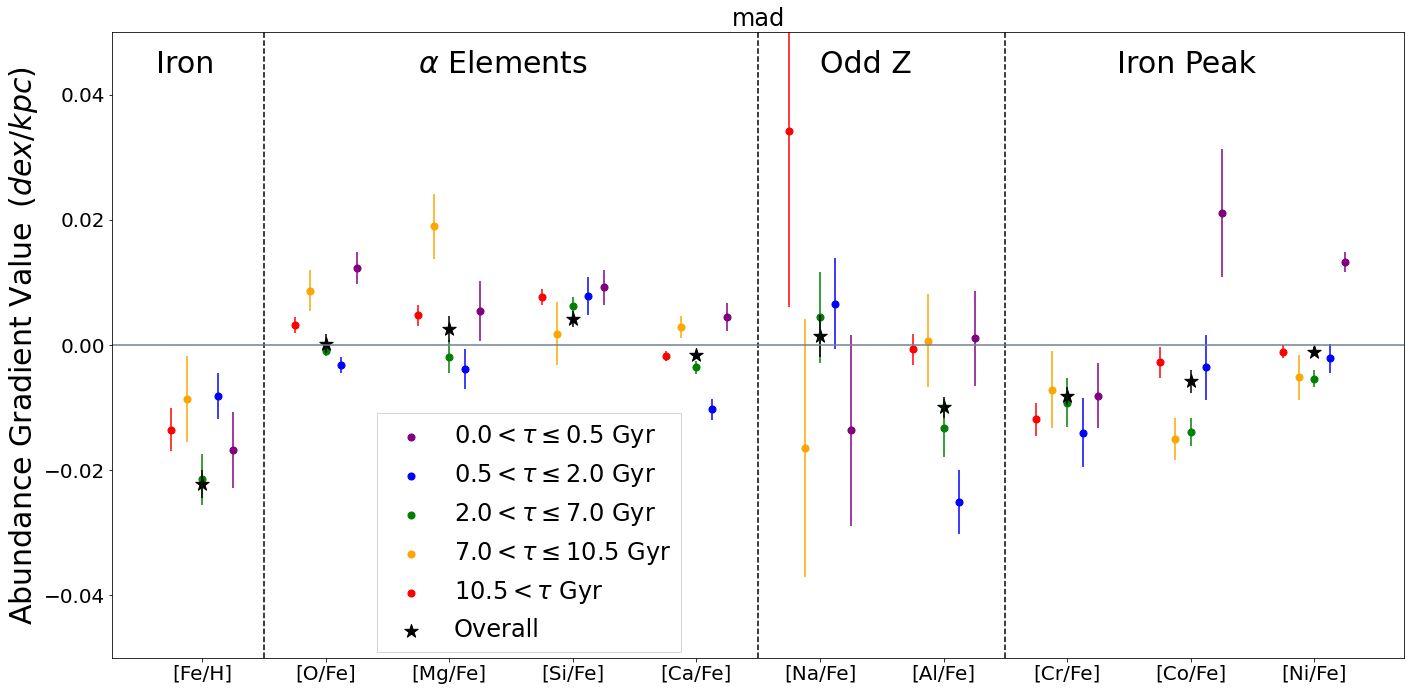

In [30]:
####################
### Summary plot ###
####################

# elements: O, Na, Mg, Al, Si, Ca, Cr, Fe, Co, Ni, V

idx = [np.squeeze(np.where(np.asarray(elems)=='FE_H')),np.squeeze(np.where(np.asarray(elems)=='O_FE')),
       np.squeeze(np.where(np.asarray(elems)=='MG_FE')),np.squeeze(np.where(np.asarray(elems)=='SI_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CA_FE')),np.squeeze(np.where(np.asarray(elems)=='NA_FE')),
       np.squeeze(np.where(np.asarray(elems)=='AL_FE')),np.squeeze(np.where(np.asarray(elems)=='CR_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CO_FE')),np.squeeze(np.where(np.asarray(elems)=='NI_FE'))]#,
       #np.squeeze(np.where(np.asarray(elems)=='V_FE'))]

good_youngmad = []
good_ylessmad = []
good_ymedmad = []
good_omedmad = []
good_oldmad = []
good_over = []

err_youngmad = []
err_ylessmad = []
err_ymedmad = []
err_omedmad = []
err_oldmad = []
err_over = []

for i in idx:
    good_youngmad.append(re_youngmad_ms[i])
    good_ylessmad.append(re_ylessmad_ms[i])
    good_ymedmad.append(re_ymedmad_ms[i])
    good_omedmad.append(re_omedmad_ms[i])
    good_oldmad.append(re_oldmad_ms[i])
    good_over.append(re_med_ms[i])
    
    err_youngmad.append(youngmad_m_devs[i])
    err_ylessmad.append(ylessmad_m_devs[i])
    err_ymedmad.append(ymedmad_m_devs[i])
    err_omedmad.append(omedmad_m_devs[i])
    err_oldmad.append(oldmad_m_devs[i])
    err_over.append(med_m_devs[i])

matplotlib.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=[20,10])

plt.scatter(np.add(np.arange(10),0.25),good_youngmad,c='purple',label='$0.0 < \\tau \leq 0.5$ Gyr',s=50)
plt.errorbar(np.add(np.arange(10),0.25),good_youngmad,yerr=err_youngmad,c='purple',ls='none')

plt.scatter(np.add(np.arange(10),0.125),good_ylessmad,c='blue',label='$0.5 < \\tau \leq 2.0$ Gyr',s=50)
plt.errorbar(np.add(np.arange(10),0.125),good_ylessmad,yerr=err_ylessmad,c='blue',ls='none')

plt.scatter([0,1,2,3,4,5,6,7,8,9],good_ymedmad,c='green',label='$2.0 < \\tau \leq 7.0$ Gyr',s=50)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_ymedmad,yerr=err_ymedmad,c='green',ls='none')

plt.scatter(np.subtract(np.arange(10),0.125),good_omedmad,c='orange',label='$7.0 < \\tau \leq 10.5$ Gyr',s=50)
plt.errorbar(np.subtract(np.arange(10),0.125),good_omedmad,yerr=err_omedmad,c='orange',ls='none')

plt.scatter(np.subtract(np.arange(10),0.25),good_oldmad,c='red',label='$10.5 < \\tau $ Gyr',s=50)
plt.errorbar(np.subtract(np.arange(10),0.25),good_oldmad,yerr=err_oldmad,c='red',ls='none')

plt.scatter([0,1,2,3,4,5,6,7,8,9],good_over,marker='*',c='black',label='Overall',s=200)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_over,yerr=err_over,c='black',ls='none')

xplotlab = ['[Fe/H]','[O/Fe]','[Mg/Fe]','[Si/Fe]','[Ca/Fe]','[Na/Fe]','[Al/Fe]','[Cr/Fe]','[Co/Fe]',
            '[Ni/Fe]']#,'[V/Fe]']

xplotpos = [0,1,2,3,4,5,6,7,8,9]#,10] 
plt.xticks(xplotpos,xplotlab)

plt.axvline(0.5,c='k',ls='--')
plt.axvline(4.5,c='k',ls='--')
plt.axvline(6.5,c='k',ls='--')
plt.axhline(0.0,c='slategrey',ls='-')
plt.ylabel('Abundance Gradient Value $\,(dex/kpc)$',fontsize=30)

# plt.gca().set_ylim(top=0.05)

plt.text(-0.375,0.0435,'Iron',fontsize=30)
plt.text(1.75,0.0435,'$\\alpha$ Elements',fontsize=30)
plt.text(5.0,0.0435,'Odd Z',fontsize=30)
plt.text(7.4,0.0435,'Iron Peak',fontsize=30)

plt.title(r'mad')

# plt.ylim(bottom=-0.045)
plt.ylim(-0.05,0.05)

plt.legend(loc=(0.205,0.01),frameon=True,fancybox=False,fontsize='large')
plt.tight_layout()
# plt.savefig('gradientSummaryplot.png',bbox_inches='tight')
plt.show()

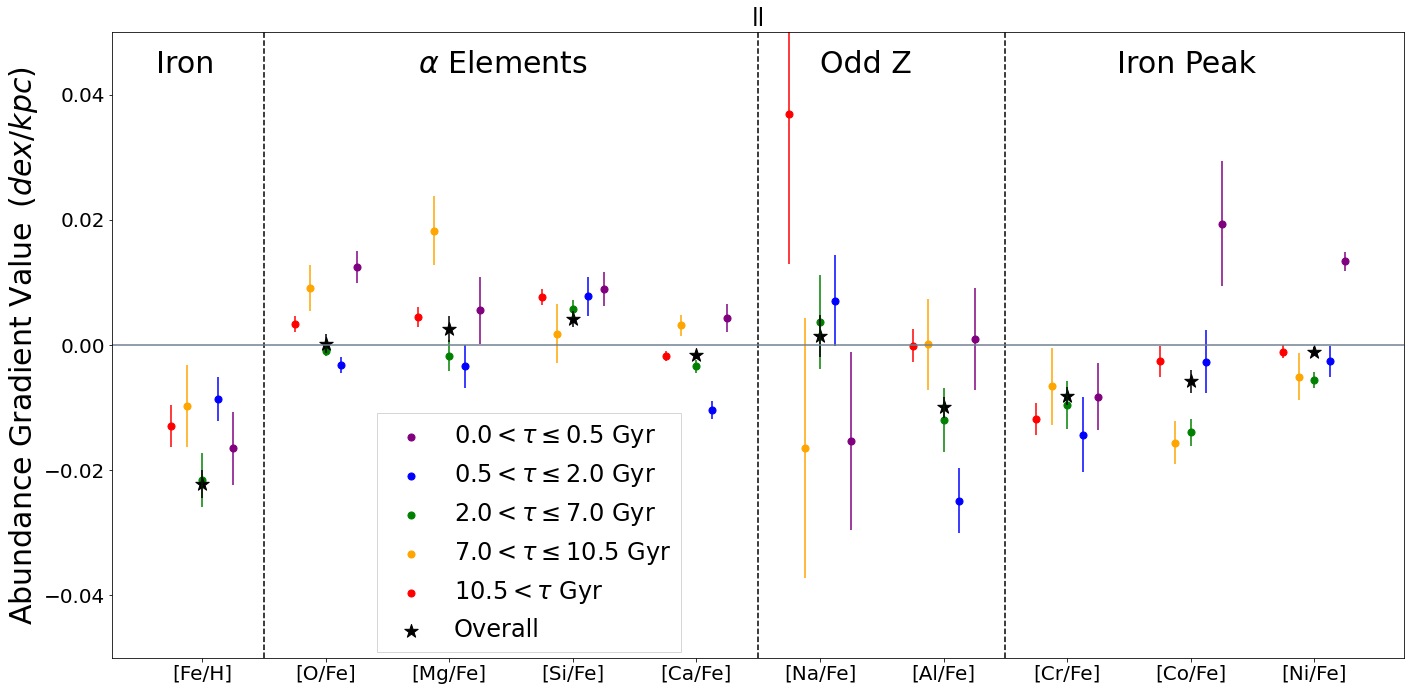

In [31]:
####################
### Summary plot ###
####################

# elements: O, Na, Mg, Al, Si, Ca, Cr, Fe, Co, Ni, V

idx = [np.squeeze(np.where(np.asarray(elems)=='FE_H')),np.squeeze(np.where(np.asarray(elems)=='O_FE')),
       np.squeeze(np.where(np.asarray(elems)=='MG_FE')),np.squeeze(np.where(np.asarray(elems)=='SI_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CA_FE')),np.squeeze(np.where(np.asarray(elems)=='NA_FE')),
       np.squeeze(np.where(np.asarray(elems)=='AL_FE')),np.squeeze(np.where(np.asarray(elems)=='CR_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CO_FE')),np.squeeze(np.where(np.asarray(elems)=='NI_FE'))]#,
       #np.squeeze(np.where(np.asarray(elems)=='V_FE'))]

good_youngll = []
good_ylessll = []
good_ymedll = []
good_omedll = []
good_oldll = []
good_over = []

err_youngll = []
err_ylessll = []
err_ymedll = []
err_omedll = []
err_oldll = []
err_over = []

for i in idx:
    good_youngll.append(re_youngll_ms[i])
    good_ylessll.append(re_ylessll_ms[i])
    good_ymedll.append(re_ymedll_ms[i])
    good_omedll.append(re_omedll_ms[i])
    good_oldll.append(re_oldll_ms[i])
    good_over.append(re_med_ms[i])
    
    err_youngll.append(youngll_m_devs[i])
    err_ylessll.append(ylessll_m_devs[i])
    err_ymedll.append(ymedll_m_devs[i])
    err_omedll.append(omedll_m_devs[i])
    err_oldll.append(oldll_m_devs[i])
    err_over.append(med_m_devs[i])

matplotlib.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=[20,10])

plt.scatter(np.add(np.arange(10),0.25),good_youngll,c='purple',label='$0.0 < \\tau \leq 0.5$ Gyr',s=50)
plt.errorbar(np.add(np.arange(10),0.25),good_youngll,yerr=err_youngll,c='purple',ls='none')

plt.scatter(np.add(np.arange(10),0.125),good_ylessll,c='blue',label='$0.5 < \\tau \leq 2.0$ Gyr',s=50)
plt.errorbar(np.add(np.arange(10),0.125),good_ylessll,yerr=err_ylessll,c='blue',ls='none')

plt.scatter([0,1,2,3,4,5,6,7,8,9],good_ymedll,c='green',label='$2.0 < \\tau \leq 7.0$ Gyr',s=50)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_ymedll,yerr=err_ymedll,c='green',ls='none')

plt.scatter(np.subtract(np.arange(10),0.125),good_omedll,c='orange',label='$7.0 < \\tau \leq 10.5$ Gyr',s=50)
plt.errorbar(np.subtract(np.arange(10),0.125),good_omedll,yerr=err_omedll,c='orange',ls='none')

plt.scatter(np.subtract(np.arange(10),0.25),good_oldll,c='red',label='$10.5 < \\tau $ Gyr',s=50)
plt.errorbar(np.subtract(np.arange(10),0.25),good_oldll,yerr=err_oldll,c='red',ls='none')

plt.scatter([0,1,2,3,4,5,6,7,8,9],good_over,marker='*',c='black',label='Overall',s=200)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_over,yerr=err_over,c='black',ls='none')

xplotlab = ['[Fe/H]','[O/Fe]','[Mg/Fe]','[Si/Fe]','[Ca/Fe]','[Na/Fe]','[Al/Fe]','[Cr/Fe]','[Co/Fe]',
            '[Ni/Fe]']#,'[V/Fe]']

xplotpos = [0,1,2,3,4,5,6,7,8,9]#,10] 
plt.xticks(xplotpos,xplotlab)

plt.axvline(0.5,c='k',ls='--')
plt.axvline(4.5,c='k',ls='--')
plt.axvline(6.5,c='k',ls='--')
plt.axhline(0.0,c='slategrey',ls='-')
plt.ylabel('Abundance Gradient Value $\,(dex/kpc)$',fontsize=30)

# plt.gca().set_ylim(top=0.05)

plt.text(-0.375,0.0435,'Iron',fontsize=30)
plt.text(1.75,0.0435,'$\\alpha$ Elements',fontsize=30)
plt.text(5.0,0.0435,'Odd Z',fontsize=30)
plt.text(7.4,0.0435,'Iron Peak',fontsize=30)

plt.title(r'll')

# plt.ylim(bottom=-0.045)
plt.ylim(-0.05,0.05)

plt.legend(loc=(0.205,0.01),frameon=True,fancybox=False,fontsize='large')
plt.tight_layout()
# plt.savefig('gradientSummaryplot.png',bbox_inches='tight')
plt.show()

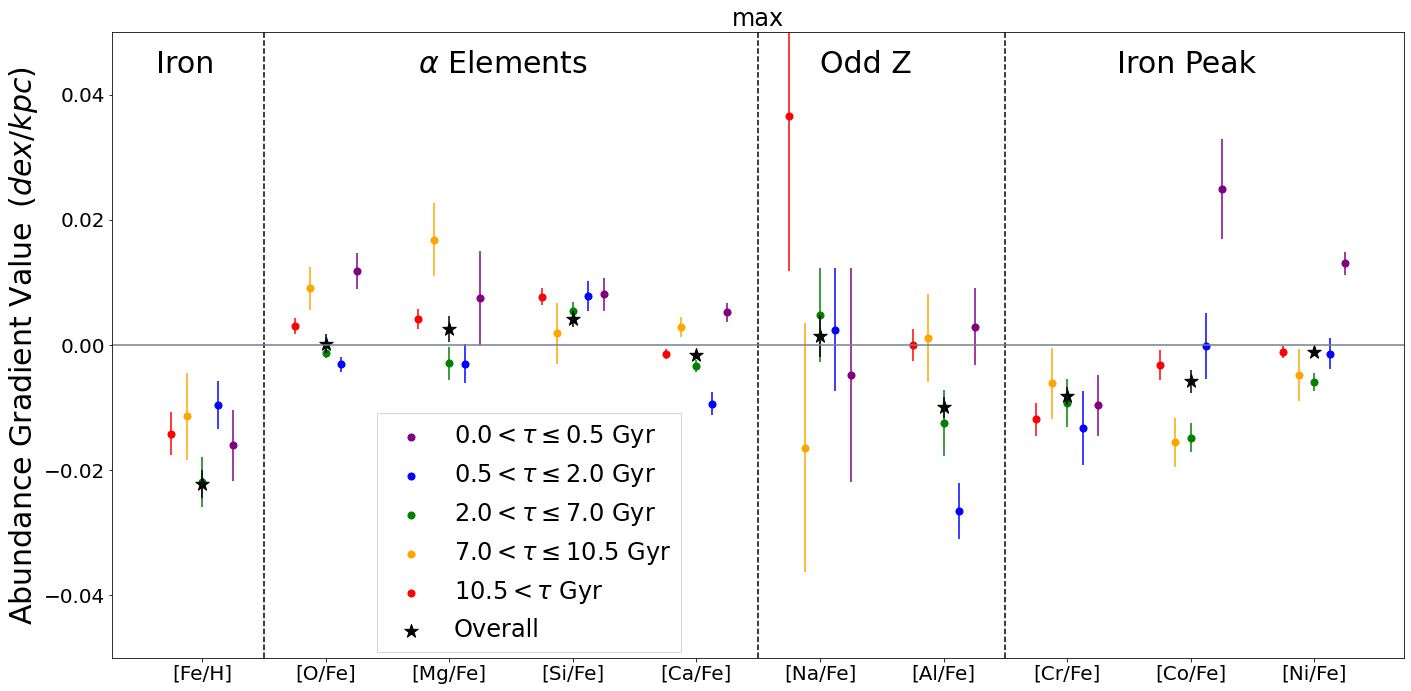

In [32]:
####################
### Summary plot ###
####################

# elements: O, Na, Mg, Al, Si, Ca, Cr, Fe, Co, Ni, V

idx = [np.squeeze(np.where(np.asarray(elems)=='FE_H')),np.squeeze(np.where(np.asarray(elems)=='O_FE')),
       np.squeeze(np.where(np.asarray(elems)=='MG_FE')),np.squeeze(np.where(np.asarray(elems)=='SI_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CA_FE')),np.squeeze(np.where(np.asarray(elems)=='NA_FE')),
       np.squeeze(np.where(np.asarray(elems)=='AL_FE')),np.squeeze(np.where(np.asarray(elems)=='CR_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CO_FE')),np.squeeze(np.where(np.asarray(elems)=='NI_FE'))]#,
       #np.squeeze(np.where(np.asarray(elems)=='V_FE'))]

good_youngmax = []
good_ylessmax = []
good_ymedmax = []
good_omedmax = []
good_oldmax = []
good_over = []

err_youngmax = []
err_ylessmax = []
err_ymedmax = []
err_omedmax = []
err_oldmax = []
err_over = []

for i in idx:
    good_youngmax.append(re_youngmax_ms[i])
    good_ylessmax.append(re_ylessmax_ms[i])
    good_ymedmax.append(re_ymedmax_ms[i])
    good_omedmax.append(re_omedmax_ms[i])
    good_oldmax.append(re_oldmax_ms[i])
    good_over.append(re_med_ms[i])
    
    err_youngmax.append(youngmax_m_devs[i])
    err_ylessmax.append(ylessmax_m_devs[i])
    err_ymedmax.append(ymedmax_m_devs[i])
    err_omedmax.append(omedmax_m_devs[i])
    err_oldmax.append(oldmax_m_devs[i])
    err_over.append(med_m_devs[i])

matplotlib.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=[20,10])

plt.scatter(np.add(np.arange(10),0.25),good_youngmax,c='purple',label='$0.0 < \\tau \leq 0.5$ Gyr',s=50)
plt.errorbar(np.add(np.arange(10),0.25),good_youngmax,yerr=err_youngmax,c='purple',ls='none')

plt.scatter(np.add(np.arange(10),0.125),good_ylessmax,c='blue',label='$0.5 < \\tau \leq 2.0$ Gyr',s=50)
plt.errorbar(np.add(np.arange(10),0.125),good_ylessmax,yerr=err_ylessmax,c='blue',ls='none')

plt.scatter([0,1,2,3,4,5,6,7,8,9],good_ymedmax,c='green',label='$2.0 < \\tau \leq 7.0$ Gyr',s=50)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_ymedmax,yerr=err_ymedmax,c='green',ls='none')

plt.scatter(np.subtract(np.arange(10),0.125),good_omedmax,c='orange',label='$7.0 < \\tau \leq 10.5$ Gyr',s=50)
plt.errorbar(np.subtract(np.arange(10),0.125),good_omedmax,yerr=err_omedmax,c='orange',ls='none')

plt.scatter(np.subtract(np.arange(10),0.25),good_oldmax,c='red',label='$10.5 < \\tau $ Gyr',s=50)
plt.errorbar(np.subtract(np.arange(10),0.25),good_oldmax,yerr=err_oldmax,c='red',ls='none')

plt.scatter([0,1,2,3,4,5,6,7,8,9],good_over,marker='*',c='black',label='Overall',s=200)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_over,yerr=err_over,c='black',ls='none')

xplotlab = ['[Fe/H]','[O/Fe]','[Mg/Fe]','[Si/Fe]','[Ca/Fe]','[Na/Fe]','[Al/Fe]','[Cr/Fe]','[Co/Fe]',
            '[Ni/Fe]']#,'[V/Fe]']

xplotpos = [0,1,2,3,4,5,6,7,8,9]#,10] 
plt.xticks(xplotpos,xplotlab)

plt.axvline(0.5,c='k',ls='--')
plt.axvline(4.5,c='k',ls='--')
plt.axvline(6.5,c='k',ls='--')
plt.axhline(0.0,c='slategrey',ls='-')
plt.ylabel('Abundance Gradient Value $\,(dex/kpc)$',fontsize=30)

# plt.gca().set_ylim(top=0.05)

plt.text(-0.375,0.0435,'Iron',fontsize=30)
plt.text(1.75,0.0435,'$\\alpha$ Elements',fontsize=30)
plt.text(5.0,0.0435,'Odd Z',fontsize=30)
plt.text(7.4,0.0435,'Iron Peak',fontsize=30)

plt.title(r'max')

# plt.ylim(bottom=-0.045)
plt.ylim(-0.05,0.05)

plt.legend(loc=(0.205,0.01),frameon=True,fancybox=False,fontsize='large')
plt.tight_layout()
# plt.savefig('gradientSummaryplot.png',bbox_inches='tight')
plt.show()

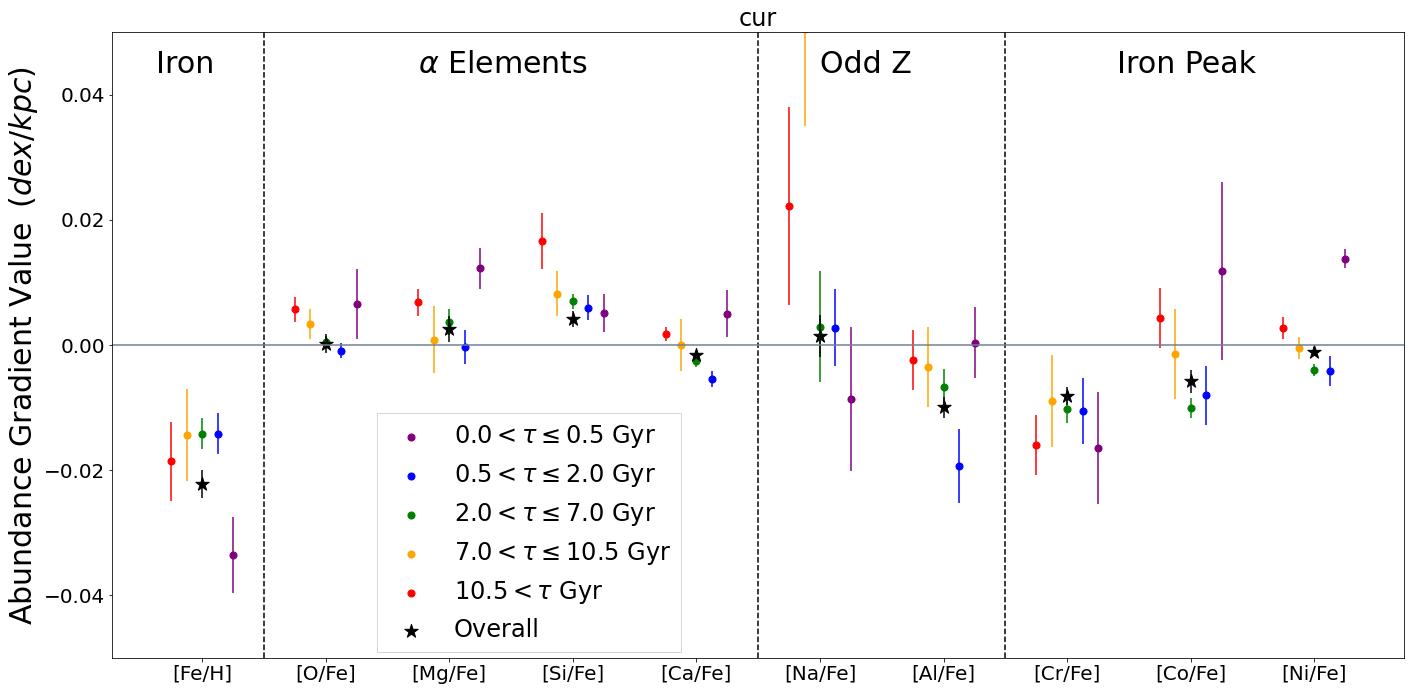

In [33]:
####################
### Summary plot ###
####################

# elements: O, Na, Mg, Al, Si, Ca, Cr, Fe, Co, Ni, V

idx = [np.squeeze(np.where(np.asarray(elems)=='FE_H')),np.squeeze(np.where(np.asarray(elems)=='O_FE')),
       np.squeeze(np.where(np.asarray(elems)=='MG_FE')),np.squeeze(np.where(np.asarray(elems)=='SI_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CA_FE')),np.squeeze(np.where(np.asarray(elems)=='NA_FE')),
       np.squeeze(np.where(np.asarray(elems)=='AL_FE')),np.squeeze(np.where(np.asarray(elems)=='CR_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CO_FE')),np.squeeze(np.where(np.asarray(elems)=='NI_FE'))]#,
       #np.squeeze(np.where(np.asarray(elems)=='V_FE'))]

good_youngcur = []
good_ylesscur = []
good_ymedcur = []
good_omedcur = []
good_oldcur = []
good_over = []

err_youngcur = []
err_ylesscur = []
err_ymedcur = []
err_omedcur = []
err_oldcur = []
err_over = []

for i in idx:
    good_youngcur.append(re_youngcur_ms[i])
    good_ylesscur.append(re_ylesscur_ms[i])
    good_ymedcur.append(re_ymedcur_ms[i])
    good_omedcur.append(re_omedcur_ms[i])
    good_oldcur.append(re_oldcur_ms[i])
    good_over.append(re_med_ms[i])
    
    err_youngcur.append(youngcur_m_devs[i])
    err_ylesscur.append(ylesscur_m_devs[i])
    err_ymedcur.append(ymedcur_m_devs[i])
    err_omedcur.append(omedcur_m_devs[i])
    err_oldcur.append(oldcur_m_devs[i])
    err_over.append(med_m_devs[i])

matplotlib.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=[20,10])

plt.scatter(np.add(np.arange(10),0.25),good_youngcur,c='purple',label='$0.0 < \\tau \leq 0.5$ Gyr',s=50)
plt.errorbar(np.add(np.arange(10),0.25),good_youngcur,yerr=err_youngcur,c='purple',ls='none')

plt.scatter(np.add(np.arange(10),0.125),good_ylesscur,c='blue',label='$0.5 < \\tau \leq 2.0$ Gyr',s=50)
plt.errorbar(np.add(np.arange(10),0.125),good_ylesscur,yerr=err_ylesscur,c='blue',ls='none')

plt.scatter([0,1,2,3,4,5,6,7,8,9],good_ymedcur,c='green',label='$2.0 < \\tau \leq 7.0$ Gyr',s=50)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_ymedcur,yerr=err_ymedcur,c='green',ls='none')

plt.scatter(np.subtract(np.arange(10),0.125),good_omedcur,c='orange',label='$7.0 < \\tau \leq 10.5$ Gyr',s=50)
plt.errorbar(np.subtract(np.arange(10),0.125),good_omedcur,yerr=err_omedcur,c='orange',ls='none')

plt.scatter(np.subtract(np.arange(10),0.25),good_oldcur,c='red',label='$10.5 < \\tau $ Gyr',s=50)
plt.errorbar(np.subtract(np.arange(10),0.25),good_oldcur,yerr=err_oldcur,c='red',ls='none')

plt.scatter([0,1,2,3,4,5,6,7,8,9],good_over,marker='*',c='black',label='Overall',s=200)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_over,yerr=err_over,c='black',ls='none')

xplotlab = ['[Fe/H]','[O/Fe]','[Mg/Fe]','[Si/Fe]','[Ca/Fe]','[Na/Fe]','[Al/Fe]','[Cr/Fe]','[Co/Fe]',
            '[Ni/Fe]']#,'[V/Fe]']

xplotpos = [0,1,2,3,4,5,6,7,8,9]#,10] 
plt.xticks(xplotpos,xplotlab)

plt.axvline(0.5,c='k',ls='--')
plt.axvline(4.5,c='k',ls='--')
plt.axvline(6.5,c='k',ls='--')
plt.axhline(0.0,c='slategrey',ls='-')
plt.ylabel('Abundance Gradient Value $\,(dex/kpc)$',fontsize=30)

# plt.gca().set_ylim(top=0.05)

plt.text(-0.375,0.0435,'Iron',fontsize=30)
plt.text(1.75,0.0435,'$\\alpha$ Elements',fontsize=30)
plt.text(5.0,0.0435,'Odd Z',fontsize=30)
plt.text(7.4,0.0435,'Iron Peak',fontsize=30)

plt.title(r'cur')

# plt.ylim(bottom=-0.045)
plt.ylim(-0.05,0.05)

plt.legend(loc=(0.205,0.01),frameon=True,fancybox=False,fontsize='large')
plt.tight_layout()
# plt.savefig('gradientSummaryplot.png',bbox_inches='tight')
plt.show()

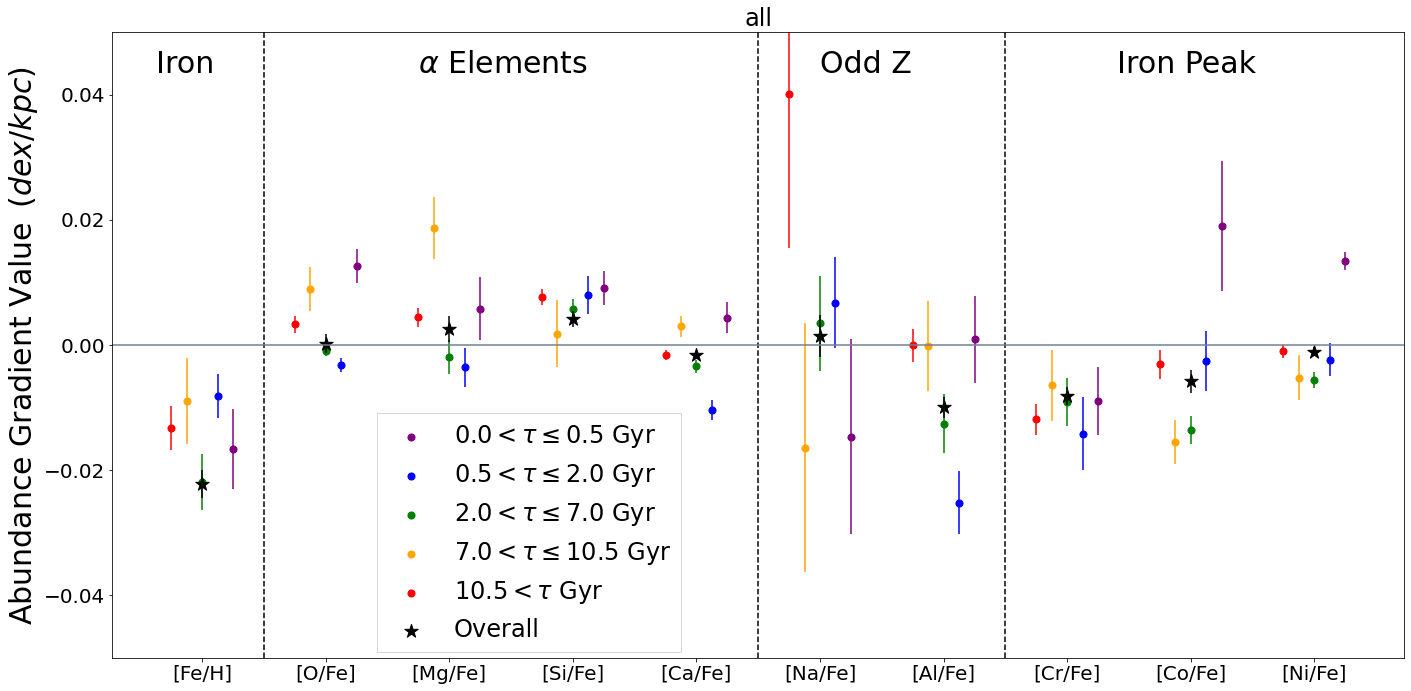

In [34]:
####################
### Summary plot ###
####################

# elements: O, Na, Mg, Al, Si, Ca, Cr, Fe, Co, Ni, V

idx = [np.squeeze(np.where(np.asarray(elems)=='FE_H')),np.squeeze(np.where(np.asarray(elems)=='O_FE')),
       np.squeeze(np.where(np.asarray(elems)=='MG_FE')),np.squeeze(np.where(np.asarray(elems)=='SI_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CA_FE')),np.squeeze(np.where(np.asarray(elems)=='NA_FE')),
       np.squeeze(np.where(np.asarray(elems)=='AL_FE')),np.squeeze(np.where(np.asarray(elems)=='CR_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CO_FE')),np.squeeze(np.where(np.asarray(elems)=='NI_FE'))]#,
       #np.squeeze(np.where(np.asarray(elems)=='V_FE'))]

good_youngall = []
good_ylessall = []
good_ymedall = []
good_omedall = []
good_oldall = []
good_over = []

err_youngall = []
err_ylessall = []
err_ymedall = []
err_omedall = []
err_oldall = []
err_over = []

for i in idx:
    good_youngall.append(re_youngall_ms[i])
    good_ylessall.append(re_ylessall_ms[i])
    good_ymedall.append(re_ymedall_ms[i])
    good_omedall.append(re_omedall_ms[i])
    good_oldall.append(re_oldall_ms[i])
    good_over.append(re_med_ms[i])
    
    err_youngall.append(youngall_m_devs[i])
    err_ylessall.append(ylessall_m_devs[i])
    err_ymedall.append(ymedall_m_devs[i])
    err_omedall.append(omedall_m_devs[i])
    err_oldall.append(oldall_m_devs[i])
    err_over.append(med_m_devs[i])

matplotlib.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=[20,10])

plt.scatter(np.add(np.arange(10),0.25),good_youngall,c='purple',label='$0.0 < \\tau \leq 0.5$ Gyr',s=50)
plt.errorbar(np.add(np.arange(10),0.25),good_youngall,yerr=err_youngall,c='purple',ls='none')

plt.scatter(np.add(np.arange(10),0.125),good_ylessall,c='blue',label='$0.5 < \\tau \leq 2.0$ Gyr',s=50)
plt.errorbar(np.add(np.arange(10),0.125),good_ylessall,yerr=err_ylessall,c='blue',ls='none')

plt.scatter([0,1,2,3,4,5,6,7,8,9],good_ymedall,c='green',label='$2.0 < \\tau \leq 7.0$ Gyr',s=50)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_ymedall,yerr=err_ymedall,c='green',ls='none')

plt.scatter(np.subtract(np.arange(10),0.125),good_omedall,c='orange',label='$7.0 < \\tau \leq 10.5$ Gyr',s=50)
plt.errorbar(np.subtract(np.arange(10),0.125),good_omedall,yerr=err_omedall,c='orange',ls='none')

plt.scatter(np.subtract(np.arange(10),0.25),good_oldall,c='red',label='$10.5 < \\tau $ Gyr',s=50)
plt.errorbar(np.subtract(np.arange(10),0.25),good_oldall,yerr=err_oldall,c='red',ls='none')

plt.scatter([0,1,2,3,4,5,6,7,8,9],good_over,marker='*',c='black',label='Overall',s=200)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_over,yerr=err_over,c='black',ls='none')

xplotlab = ['[Fe/H]','[O/Fe]','[Mg/Fe]','[Si/Fe]','[Ca/Fe]','[Na/Fe]','[Al/Fe]','[Cr/Fe]','[Co/Fe]',
            '[Ni/Fe]']#,'[V/Fe]']

xplotpos = [0,1,2,3,4,5,6,7,8,9]#,10] 
plt.xticks(xplotpos,xplotlab)

plt.axvline(0.5,c='k',ls='--')
plt.axvline(4.5,c='k',ls='--')
plt.axvline(6.5,c='k',ls='--')
plt.axhline(0.0,c='slategrey',ls='-')
plt.ylabel('Abundance Gradient Value $\,(dex/kpc)$',fontsize=30)

# plt.gca().set_ylim(top=0.05)

plt.text(-0.375,0.0435,'Iron',fontsize=30)
plt.text(1.75,0.0435,'$\\alpha$ Elements',fontsize=30)
plt.text(5.0,0.0435,'Odd Z',fontsize=30)
plt.text(7.4,0.0435,'Iron Peak',fontsize=30)

plt.title(r'all')

# plt.ylim(bottom=-0.045)
plt.ylim(-0.05,0.05)

plt.legend(loc=(0.205,0.01),frameon=True,fancybox=False,fontsize='large')
plt.tight_layout()
# plt.savefig('gradientSummaryplot.png',bbox_inches='tight')
plt.show()